## Prophet Forecasting - Rainfall & Temp

In [1]:
!pip install prophet pandas matplotlib scikit-learn

     |████████████████████████████████| 8.9 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 33.3 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 25.0 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 60.5 MB/s eta 0:00:01
     |████████████████████████████████| 181 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 957 kB 72.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 44.5 MB/s eta 0:00:01
     |████████████████████████████████| 43.9 MB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 91.8 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 6.5 MB/s  eta 0:00:01
     |██████████████████████████████

In [8]:
from prophet import Prophet
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os

In [3]:
root_wd = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'

### Step 1: Import data
The dataset has 54 countries consolidated into one. We want to process these as 54 seperate Pandas dataframes, stored in a dictionary with the country as the key.

In [4]:
def import_data(path):
    df = pd.read_csv(path)
    country_list = df['country_name'].unique()
    df_list = []
    for country in country_list:
        country_df = df[df['country_name'] == country]
        df_list.append(country_df)
    col_list = list(df)
    return df_list, country_list, col_list

In [9]:
rainfall_path = os.path.join(root_wd,"data/weather/africa_rainfall_cleaned.csv")
temp_path = os.path.join(root_wd,"data/weather/africa_temp_cleaned.csv")

mapping_df = pd.read_csv(os.path.join(root_wd,"data/africa_countries.csv"), na_filter = False)
mapping_dict = dict(mapping_df[['Country', 'Alpha-2 code']].values)

In [10]:
mapping_dict

{'Algeria': 'DZ',
 'Angola': 'AO',
 'Benin': 'BJ',
 'Botswana': 'BW',
 'Burkina Faso': 'BF',
 'Burundi': 'BI',
 'Cabo Verde': 'CV',
 'Cameroon': 'CM',
 'Central African Republic (the)': 'CF',
 'Chad': 'TD',
 'Comoros (the)': 'KM',
 'Congo (Republic of)': 'CG',
 "Côte d'Ivoire": 'CI',
 'Djibouti': 'DJ',
 'Congo (Democratic Republic of)': 'CD',
 'Egypt': 'EG',
 'Equatorial Guinea': 'GQ',
 'Eritrea': 'ER',
 'Eswatini': 'SZ',
 'Ethiopia': 'ET',
 'Gabon': 'GA',
 'Gambia (the)': 'GM',
 'Ghana': 'GH',
 'Guinea': 'GN',
 'Guinea-Bissau': 'GW',
 'Kenya': 'KE',
 'Lesotho': 'LS',
 'Liberia': 'LR',
 'Libya': 'LY',
 'Madagascar': 'MG',
 'Malawi': 'MW',
 'Mali': 'ML',
 'Mauritania': 'MR',
 'Mauritius': 'MU',
 'Morocco': 'MA',
 'Mozambique': 'MZ',
 'Namibia': 'NA',
 'Niger (the)': 'NE',
 'Nigeria': 'NG',
 'Rwanda': 'RW',
 'Sao Tome and Principe': 'ST',
 'Senegal': 'SN',
 'Seychelles': 'SC',
 'Sierra Leone': 'SL',
 'Somalia': 'SO',
 'South Africa': 'ZA',
 'South Sudan': 'SS',
 'Sudan (the)': 'SD',
 'Ta

In [11]:
rainfall_dfs, country_list, _cols = import_data(rainfall_path)
temp_dfs, _, _ = import_data(temp_path)

In [12]:
rainfall_dfs

[    country_name country_cd_alpha3 country_cd_alpha2  Year    Jan    Feb  \
 0        Algeria               DZA                DZ  1901  10.58  10.65   
 1        Algeria               DZA                DZ  1902   5.46  10.30   
 2        Algeria               DZA                DZ  1903   8.28   3.42   
 3        Algeria               DZA                DZ  1904  23.82  12.87   
 4        Algeria               DZA                DZ  1905   8.67   6.00   
 ..           ...               ...               ...   ...    ...    ...   
 116      Algeria               DZA                DZ  2017  16.19   3.16   
 117      Algeria               DZA                DZ  2018   6.83   9.05   
 118      Algeria               DZA                DZ  2019   8.32   3.35   
 119      Algeria               DZA                DZ  2020   5.23   0.87   
 120      Algeria               DZA                DZ  2021   5.43   2.52   
 
        Mar    Apr    May   Jun   Jul   Aug    Sep    Oct    Nov    Dec  


### Step 2: Convert to Timeseries
In order to feed the datasets into Prophet, we need to convert the dataframes from wide-format to long-format, and also rename them to 'ds' and 'y', the column names expected by Prophet

In [5]:
def convert_to_timeseries(df, variable,cols):
    df = pd.melt(df, id_vars=cols[:-12], value_vars=cols[-12:], var_name='month', value_name=variable)
    df['month_year'] = df['month'] + ' ' + df['Year'].astype(str)
    df['datetime'] = pd.to_datetime(df['month_year'])
    df = df[['datetime',variable]]
    df.columns = ['ds', 'y']
    return df

In [13]:
rainfall_t_dfs = [convert_to_timeseries(df, 'rainfall', _cols) for df in rainfall_dfs]
rainfall_t_dict = dict(zip(country_list, rainfall_t_dfs))
temp_t_dfs = [convert_to_timeseries(df, 'temp', _cols) for df in temp_dfs]
temp_t_dict = dict(zip(country_list, temp_t_dfs))

### Step 3: Prophet Forecasting
Use the Prophet algorithm to conduct time-series analysis and forecasting for each of the 54 countries.

In [14]:
def make_prophet_predictions(df, country, variable):
    
    # taking only the past 10 yearss
    df = df[df['ds'] > '2011-01-01'].reset_index(drop=True)

    print(f'Analysing for Country: {country}')
    model = Prophet()
    model.fit(df)
    
    # predicting for the next 24 months
    future = model.make_future_dataframe(periods=24, freq='M')
    forecast = model.predict(future)
    
    # extracting only the last 12 months
    next_year_forecast = forecast[-12:][['ds','yhat']]
    next_year_forecast['yhat'] = round(next_year_forecast['yhat'].clip(lower=0),2)
    next_year_forecast['ds'] = next_year_forecast['ds'] + timedelta(days=1)
    
    # saving images
    img_dir = os.path.join(root_wd,"images")
    _save_figs(model, forecast, img_dir, variable)

    return next_year_forecast

In [16]:
def _save_figs(model, forecast, img_dir,variable):
    if variable == 'rainfall':
        fig = model.plot(forecast, xlabel='Date', ylabel='Rainfall (mm)')
        fig.suptitle(f'Actual & Forecasted Total Monthly Rainfall (mm) for {country}')

        fig2 = model.plot_components(forecast)
        fig2.suptitle(f'Rainfall Trends for {country}')

    elif variable == 'temp':
        fig = model.plot(forecast, xlabel='Date', ylabel='Temp (C)')
        fig.suptitle(f'Actual & Forecasted Average Monthly Temperature (C) for {country}')

        fig2 = model.plot_components(forecast)
        fig2.suptitle(f'Temp Trends for {country}')

    fig.savefig(f'{img_dir}/{variable}_{country}.png') 
    fig2.savefig(f'{img_dir}/{variable}_{country}_components.png') 
    
    return

13:10:36 - cmdstanpy - INFO - Chain [1] start processing
13:10:36 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Algeria


13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:10:39 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Angola


13:10:41 - cmdstanpy - INFO - Chain [1] start processing
13:10:41 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Benin


13:10:43 - cmdstanpy - INFO - Chain [1] start processing
13:10:43 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Botswana


13:10:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:44 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Burkina Faso


13:10:46 - cmdstanpy - INFO - Chain [1] start processing
13:10:46 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Burundi


13:10:48 - cmdstanpy - INFO - Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Cabo Verde


13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Cameroon


13:10:52 - cmdstanpy - INFO - Chain [1] start processing
13:10:52 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Central African Republic (the)


13:10:54 - cmdstanpy - INFO - Chain [1] start processing
13:10:54 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Chad


13:10:56 - cmdstanpy - INFO - Chain [1] start processing
13:10:56 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Comoros (the)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/prophet/plot.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
13:10:58 - cmdstanpy - INFO - Chain [1] start processing
13:10:58 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Congo (Democratic Republic of)


13:11:00 - cmdstanpy - INFO - Chain [1] start processing
13:11:00 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Congo (Republic of)


13:11:02 - cmdstanpy - INFO - Chain [1] start processing
13:11:02 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Côte d'Ivoire


13:11:04 - cmdstanpy - INFO - Chain [1] start processing
13:11:04 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Djibouti


13:11:06 - cmdstanpy - INFO - Chain [1] start processing
13:11:06 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Egypt


13:11:07 - cmdstanpy - INFO - Chain [1] start processing
13:11:07 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Equatorial Guinea


13:11:09 - cmdstanpy - INFO - Chain [1] start processing
13:11:09 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Eritrea


13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Eswatini


13:11:14 - cmdstanpy - INFO - Chain [1] start processing
13:11:14 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Ethiopia


13:11:15 - cmdstanpy - INFO - Chain [1] start processing
13:11:15 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Gabon


13:11:17 - cmdstanpy - INFO - Chain [1] start processing
13:11:17 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Gambia (the)


13:11:19 - cmdstanpy - INFO - Chain [1] start processing
13:11:19 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Ghana


13:11:21 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Guinea


13:11:23 - cmdstanpy - INFO - Chain [1] start processing
13:11:23 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Guinea-Bissau


13:11:25 - cmdstanpy - INFO - Chain [1] start processing
13:11:25 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Kenya


13:11:27 - cmdstanpy - INFO - Chain [1] start processing
13:11:27 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Lesotho


13:11:29 - cmdstanpy - INFO - Chain [1] start processing
13:11:29 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Liberia


13:11:31 - cmdstanpy - INFO - Chain [1] start processing
13:11:31 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Libya


13:11:33 - cmdstanpy - INFO - Chain [1] start processing
13:11:33 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Madagascar


13:11:35 - cmdstanpy - INFO - Chain [1] start processing
13:11:35 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Malawi


13:11:37 - cmdstanpy - INFO - Chain [1] start processing
13:11:37 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mali


13:11:39 - cmdstanpy - INFO - Chain [1] start processing
13:11:39 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mauritania


13:11:41 - cmdstanpy - INFO - Chain [1] start processing
13:11:41 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mauritius


13:11:43 - cmdstanpy - INFO - Chain [1] start processing
13:11:43 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Morocco


13:11:44 - cmdstanpy - INFO - Chain [1] start processing
13:11:44 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mozambique


13:11:47 - cmdstanpy - INFO - Chain [1] start processing
13:11:47 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Namibia


13:11:49 - cmdstanpy - INFO - Chain [1] start processing
13:11:49 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Niger (the)


13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Nigeria


13:11:52 - cmdstanpy - INFO - Chain [1] start processing
13:11:52 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Rwanda


13:11:54 - cmdstanpy - INFO - Chain [1] start processing
13:11:55 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Sao Tome and Principe


13:11:56 - cmdstanpy - INFO - Chain [1] start processing
13:11:56 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Senegal


13:11:58 - cmdstanpy - INFO - Chain [1] start processing
13:11:58 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Seychelles


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:00 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Sierra Leone


13:12:02 - cmdstanpy - INFO - Chain [1] start processing
13:12:02 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Somalia


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: South Africa


13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: South Sudan


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Sudan (the)


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Tanzania, United Republic of


13:12:12 - cmdstanpy - INFO - Chain [1] start processing
13:12:12 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Togo


13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Tunisia


13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Uganda


13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Zambia


13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Zimbabwe


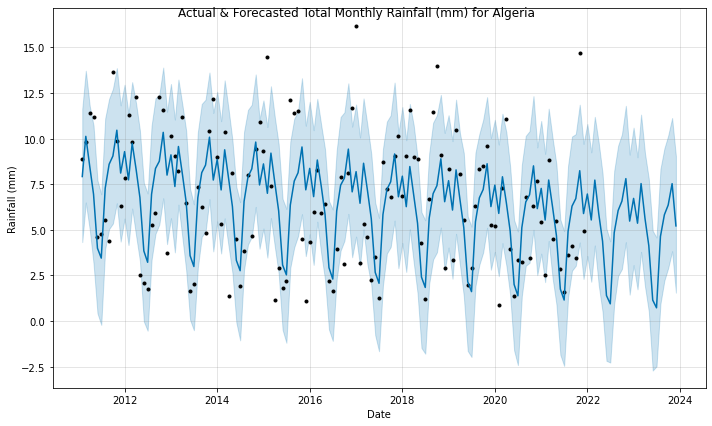

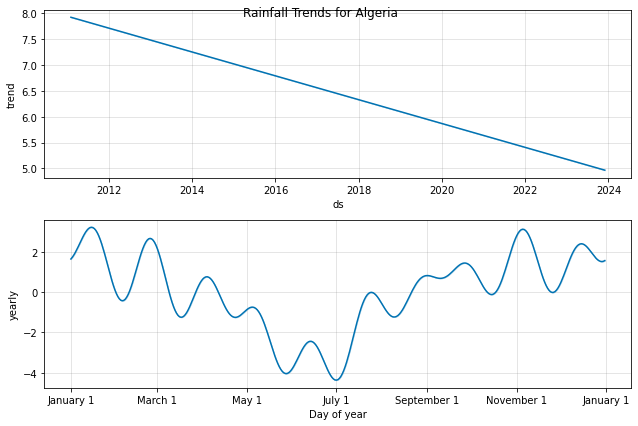

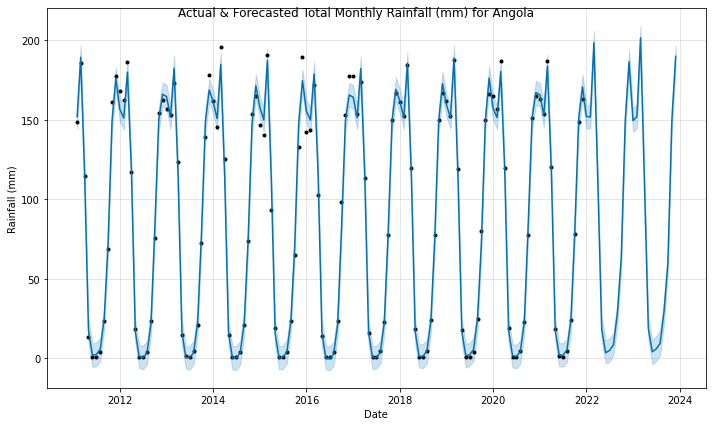

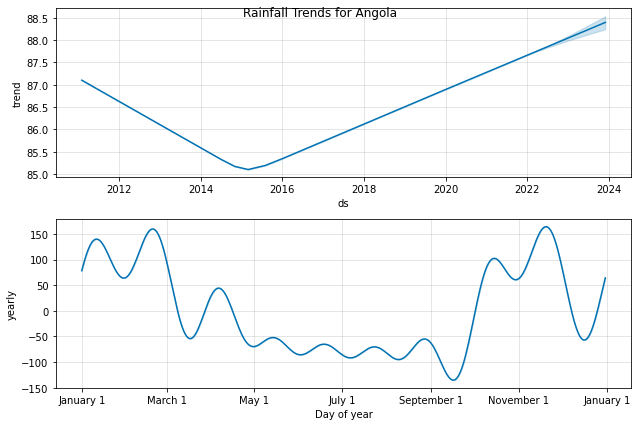

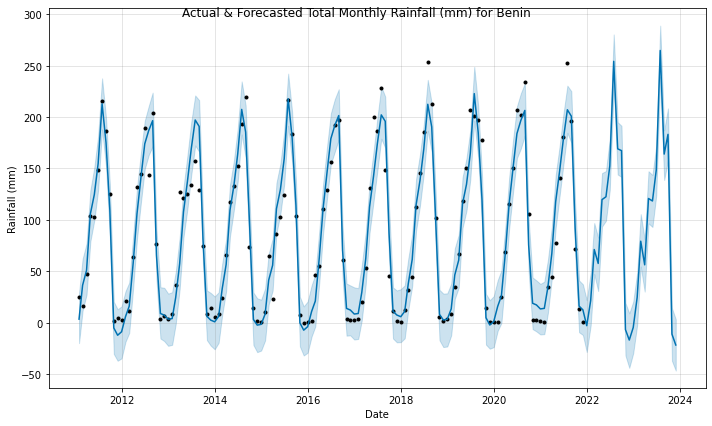

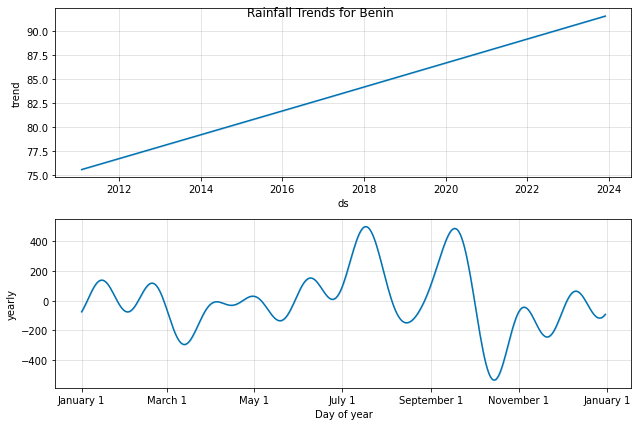

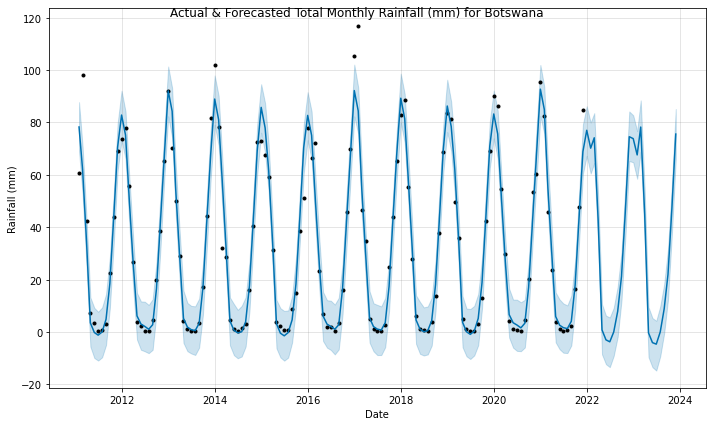

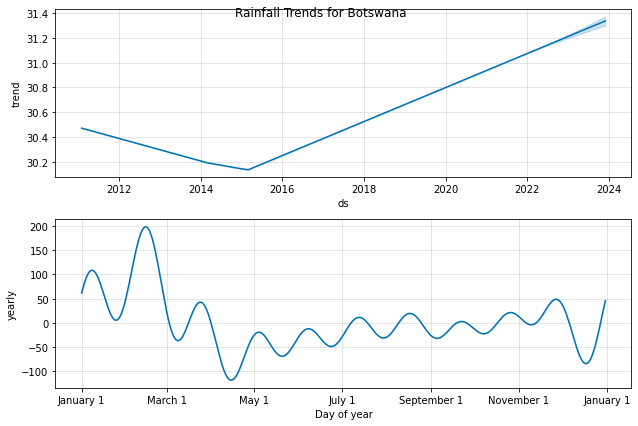

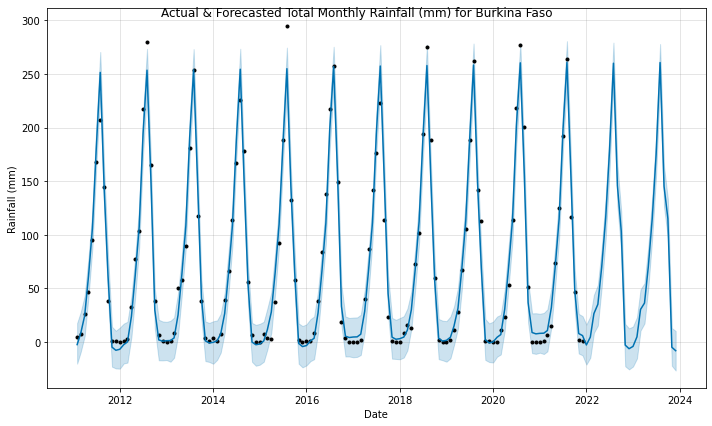

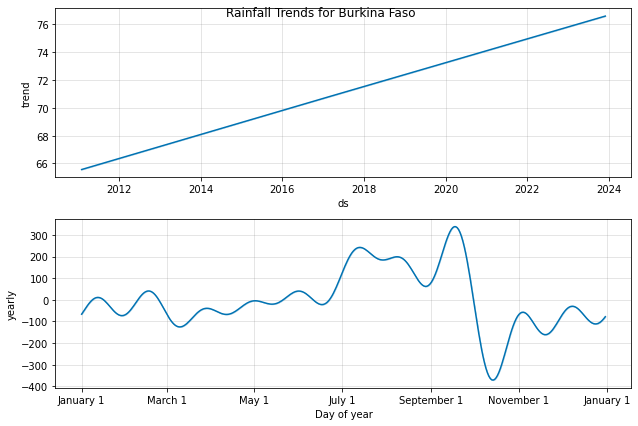

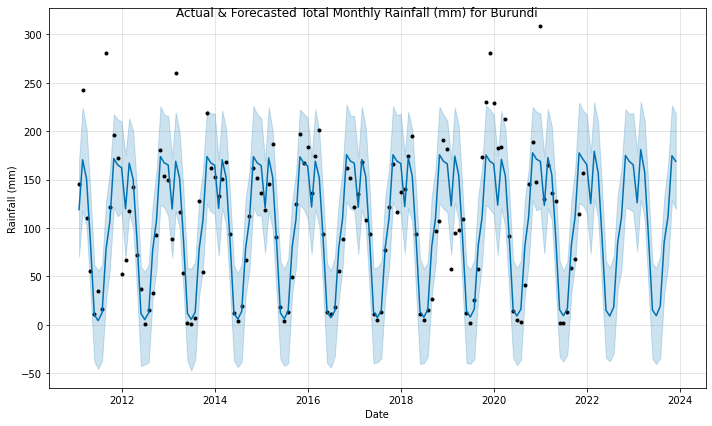

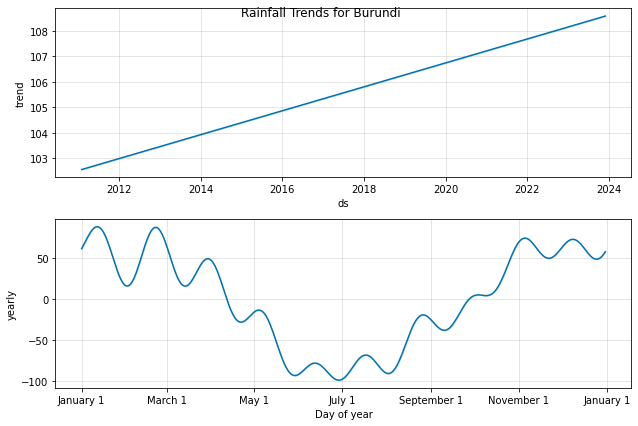

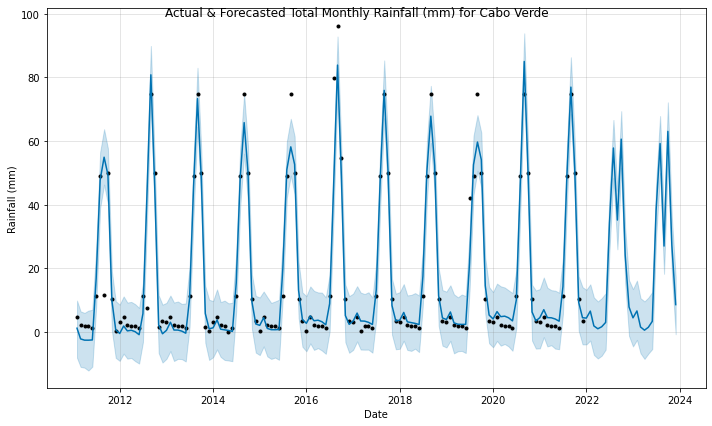

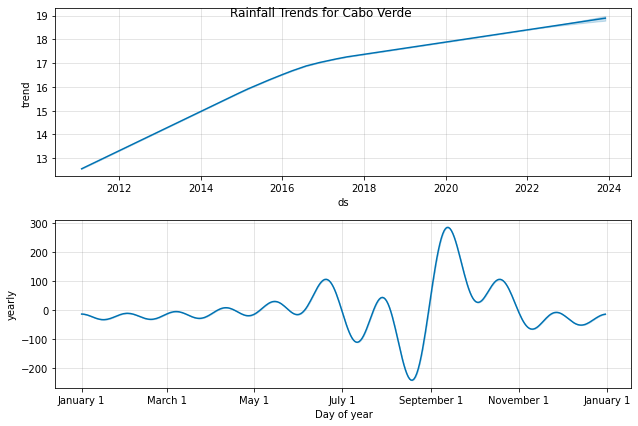

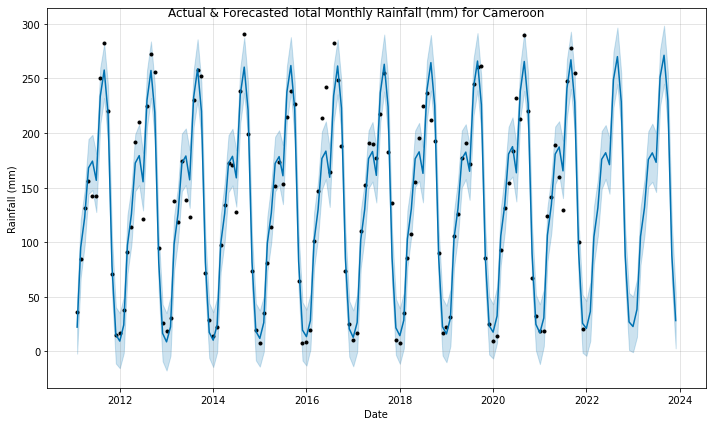

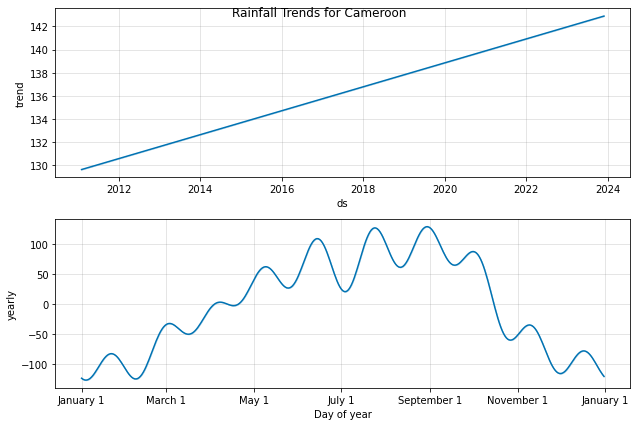

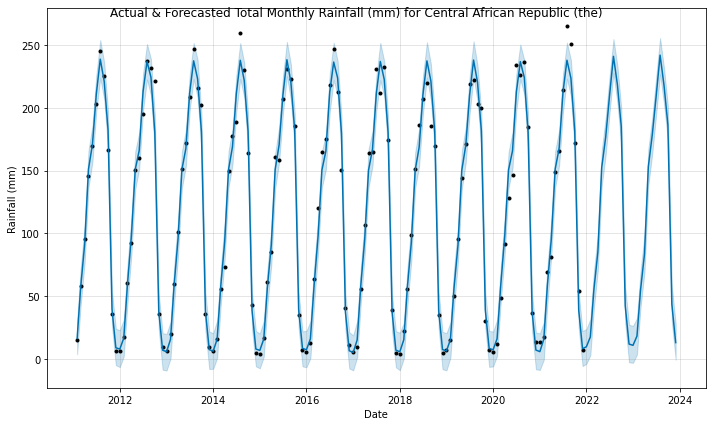

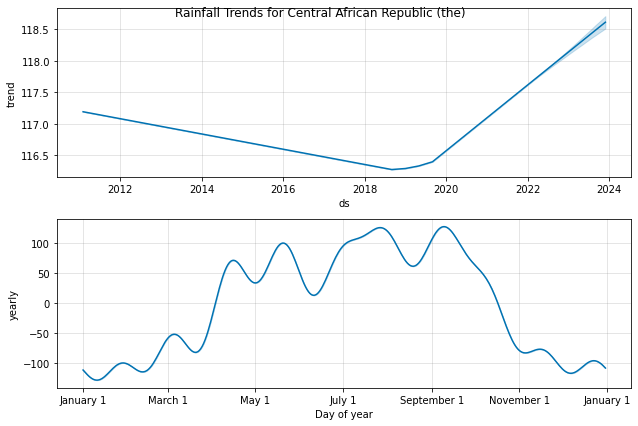

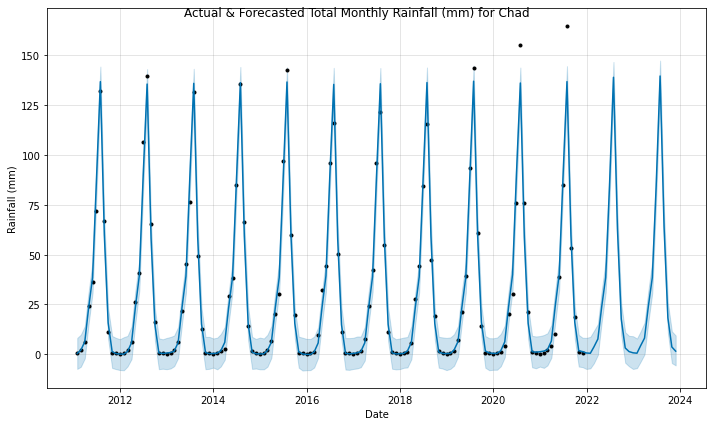

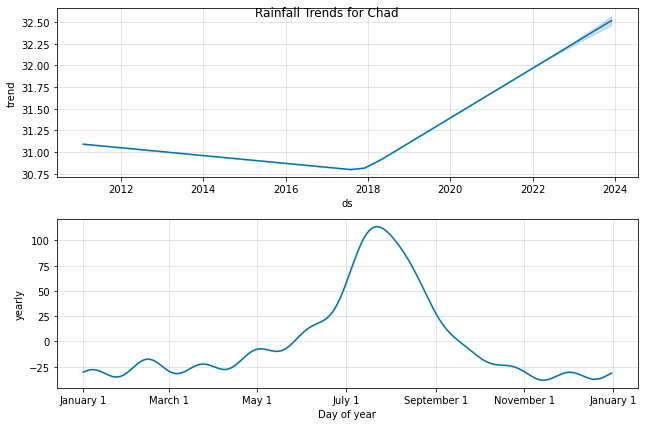

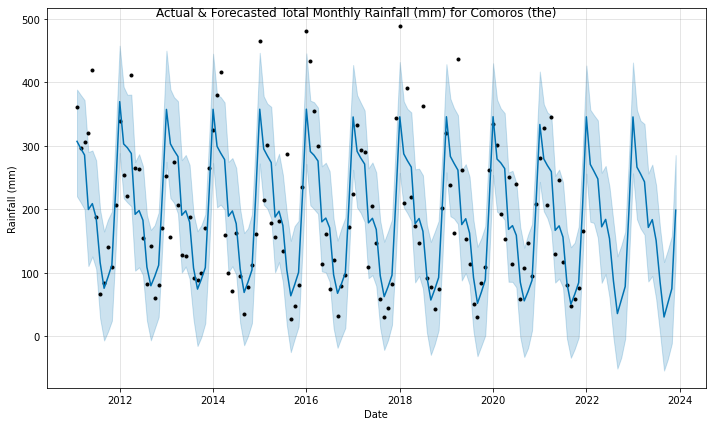

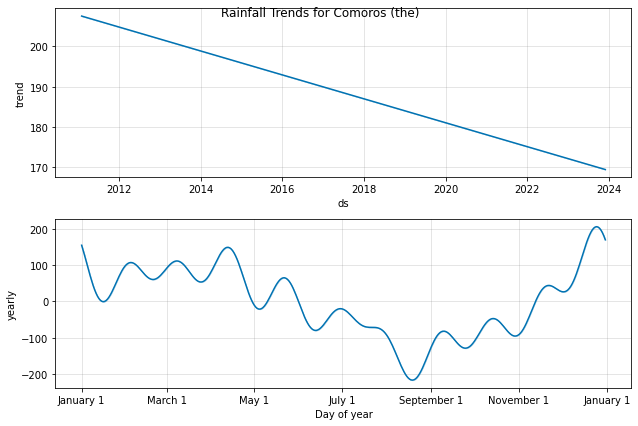

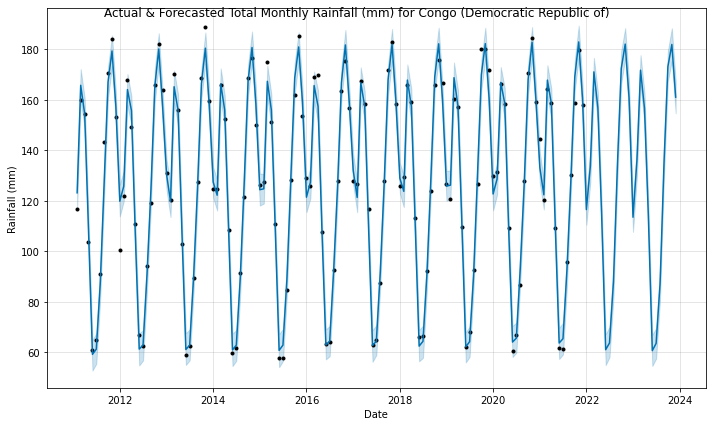

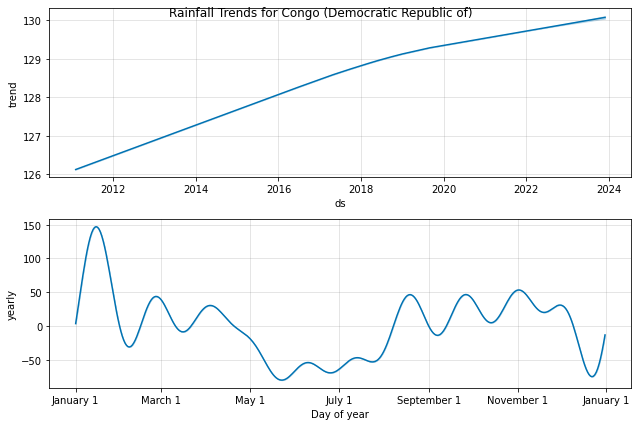

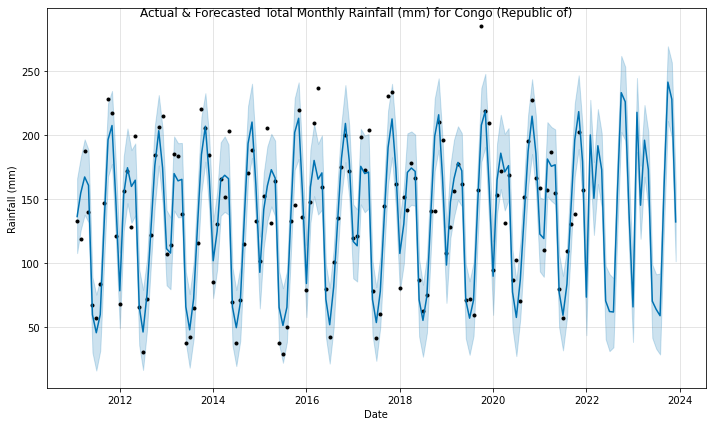

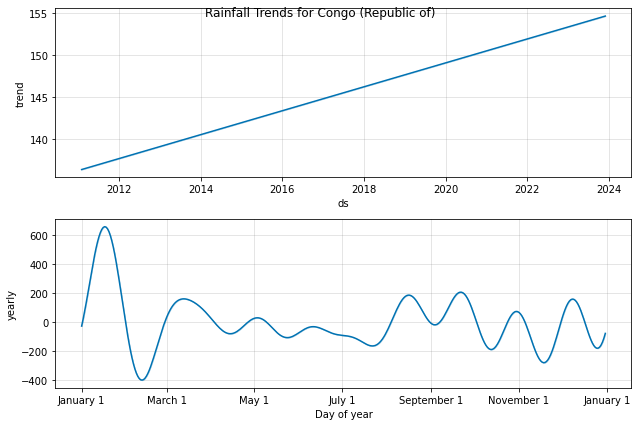

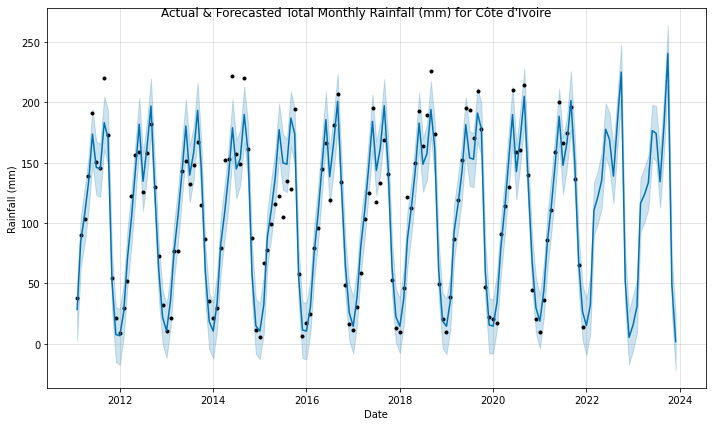

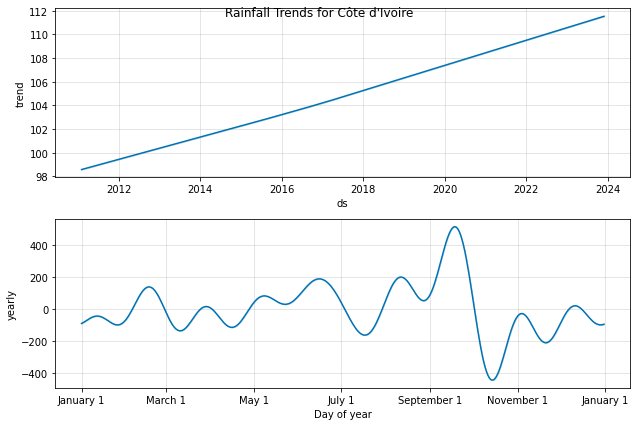

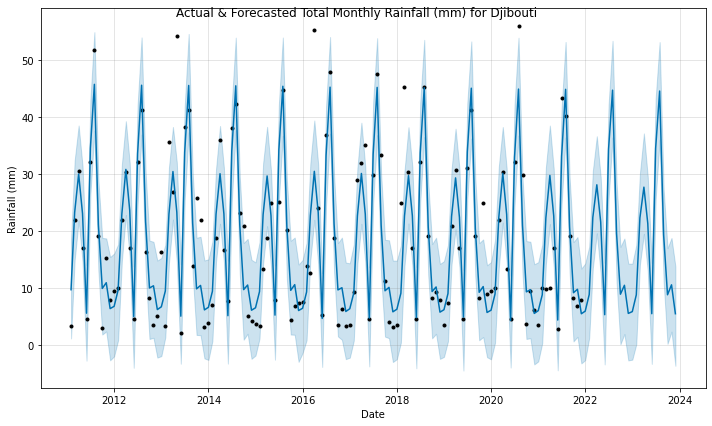

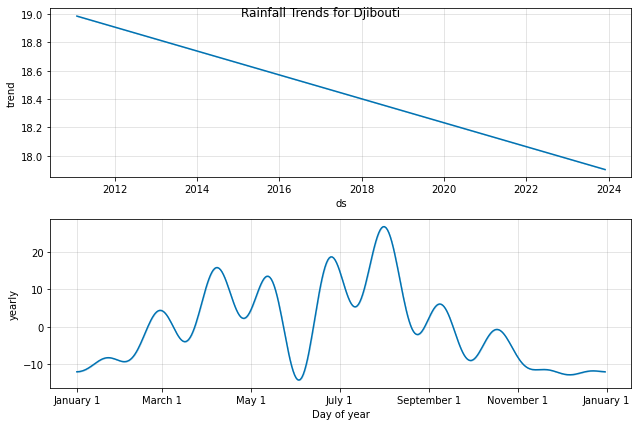

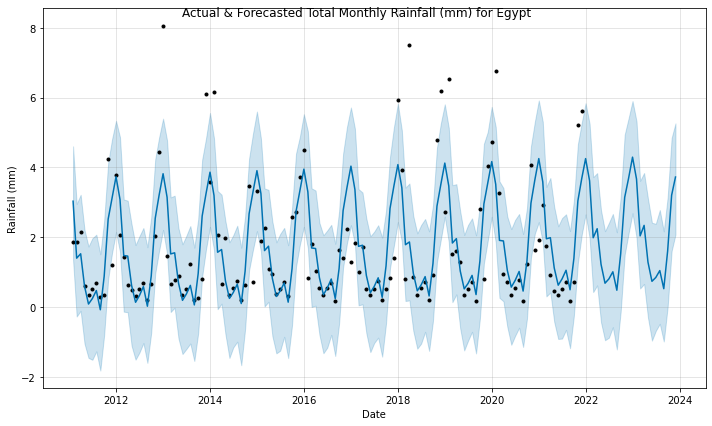

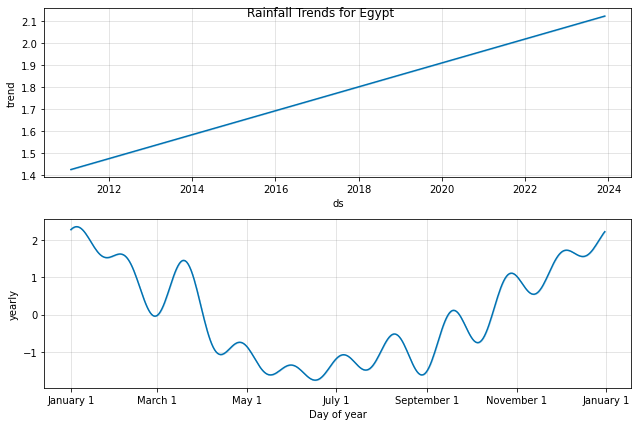

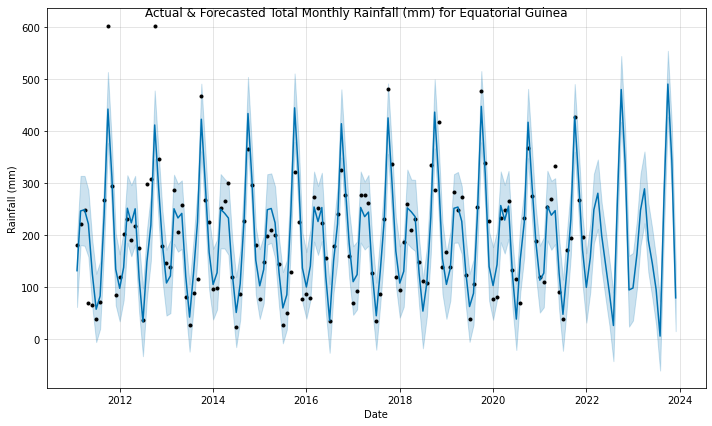

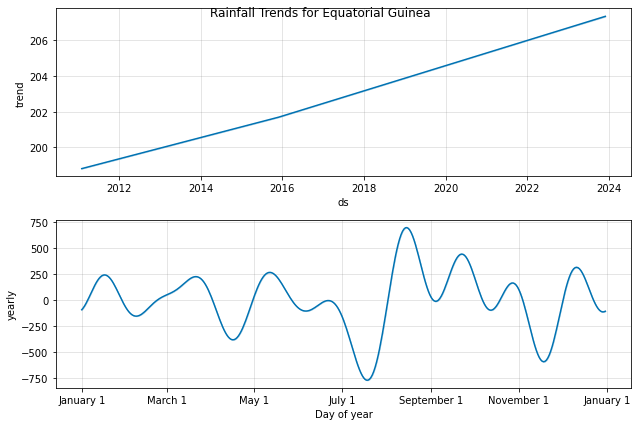

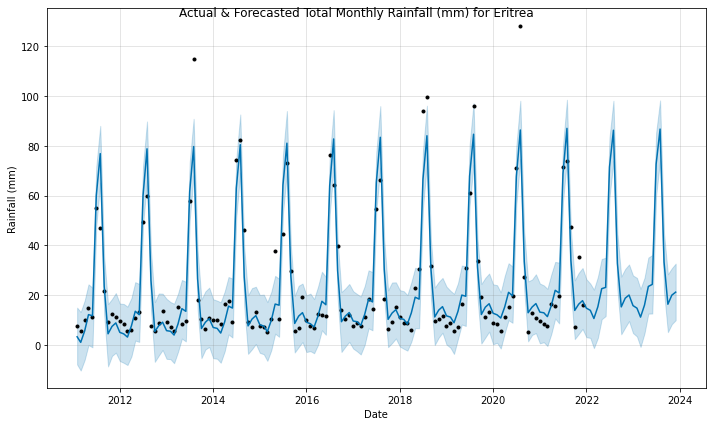

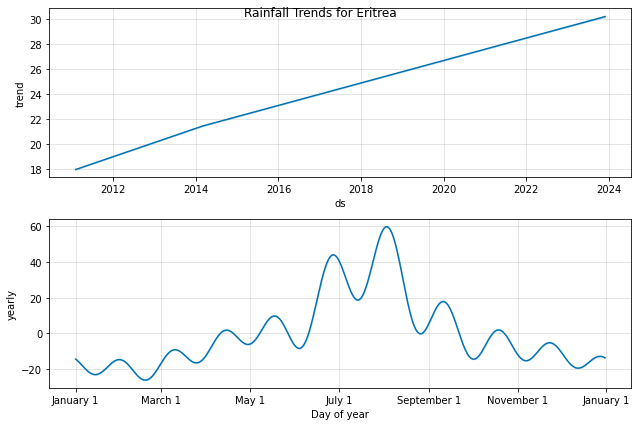

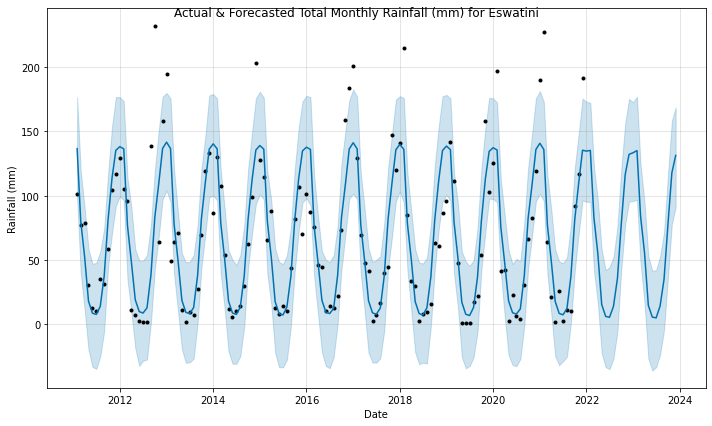

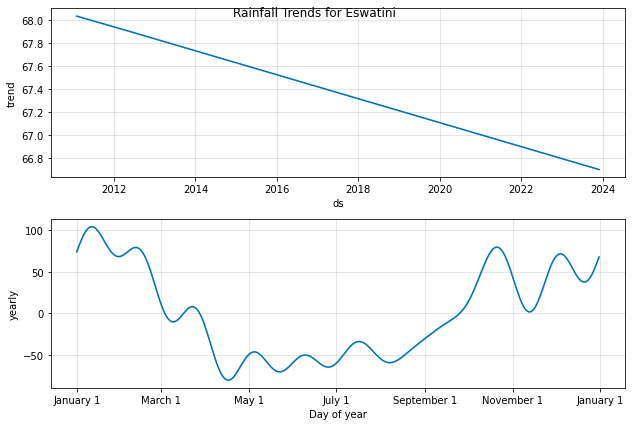

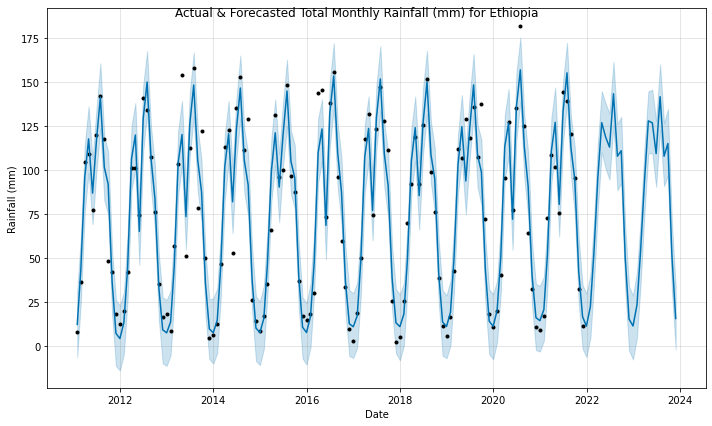

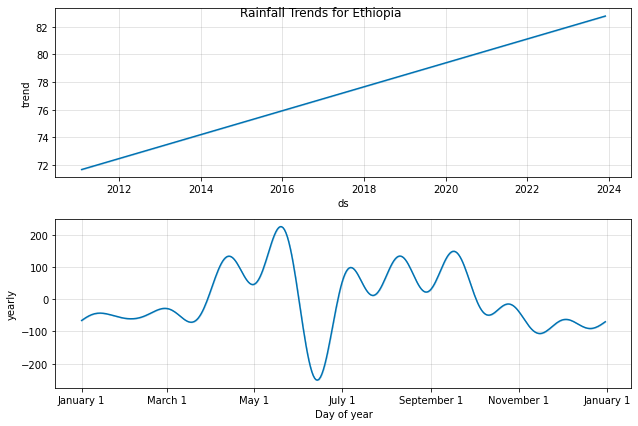

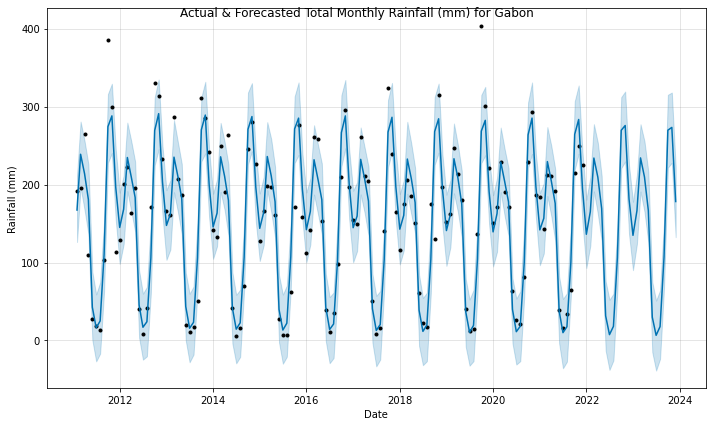

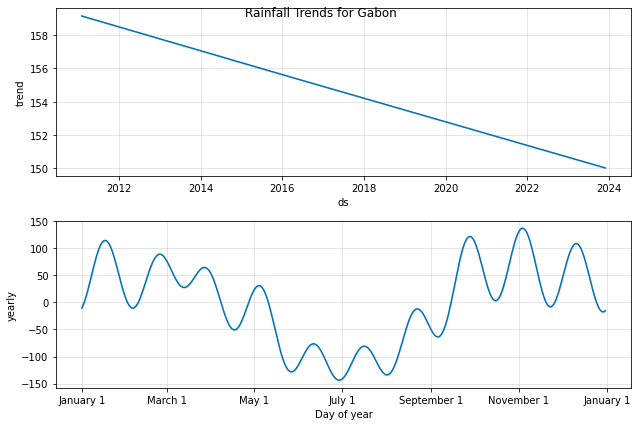

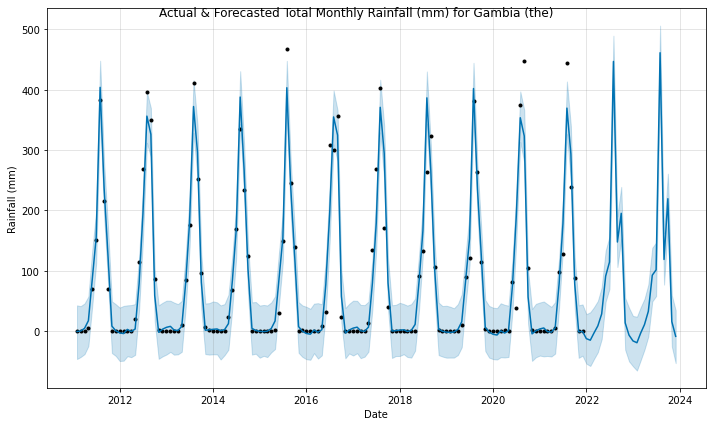

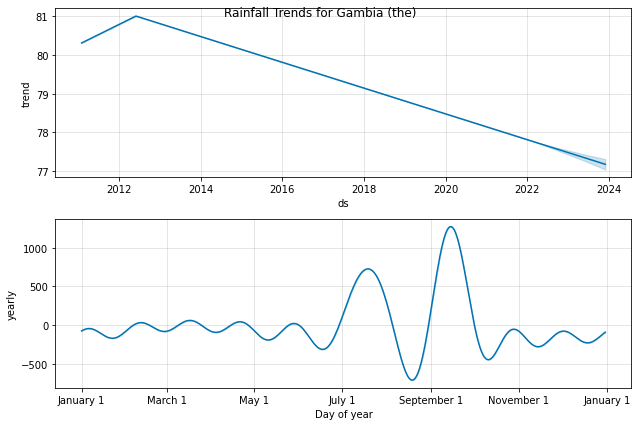

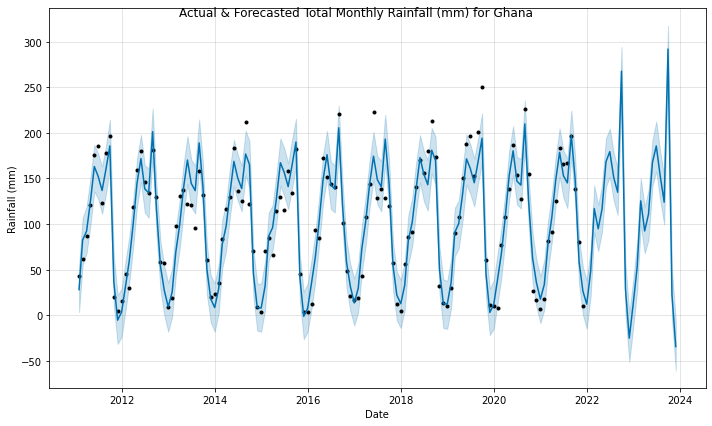

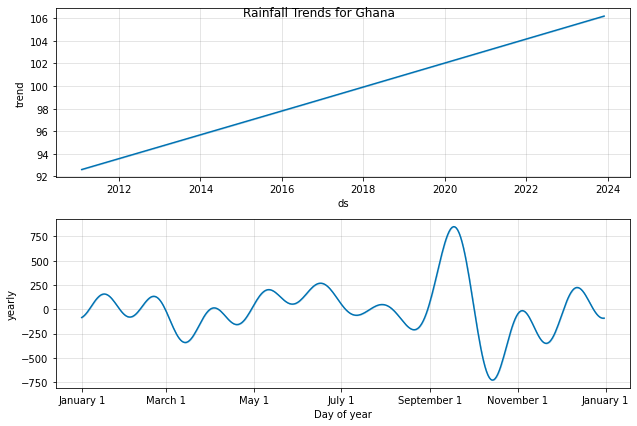

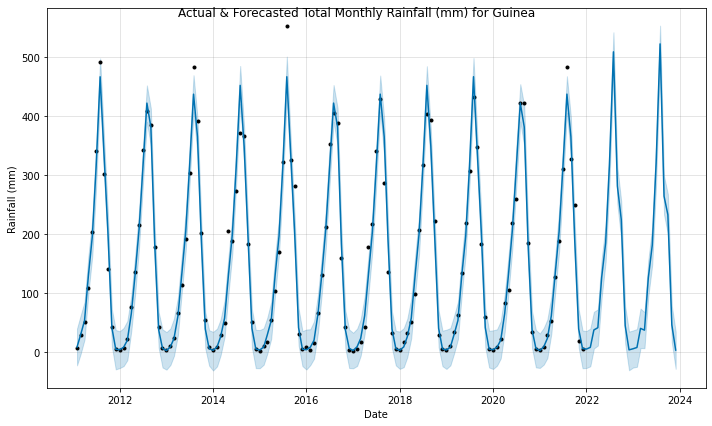

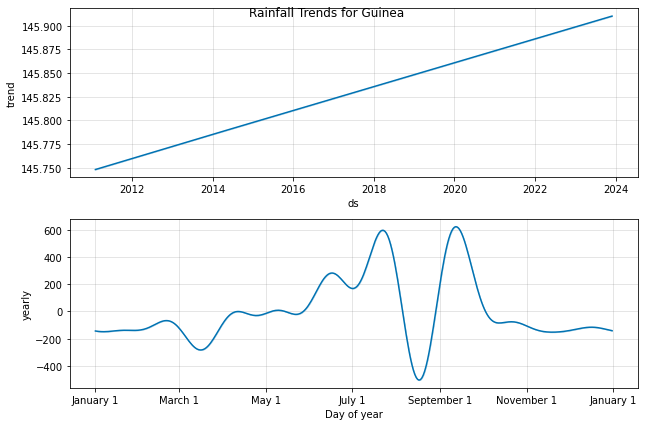

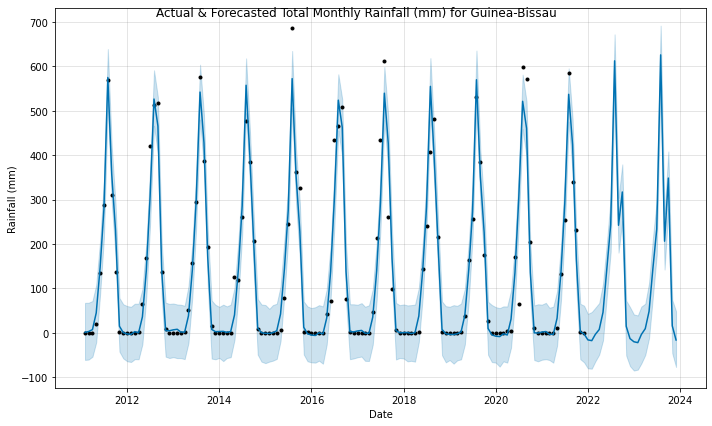

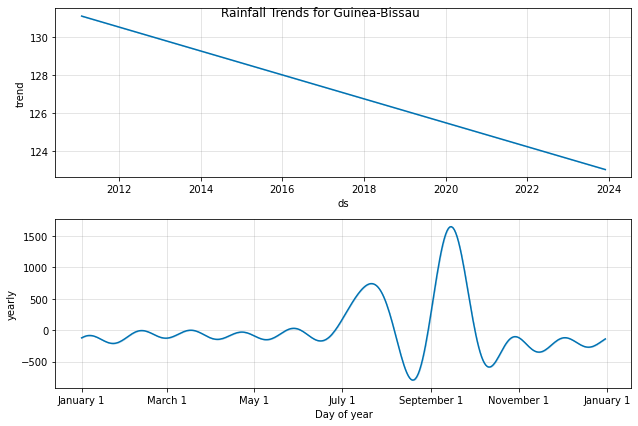

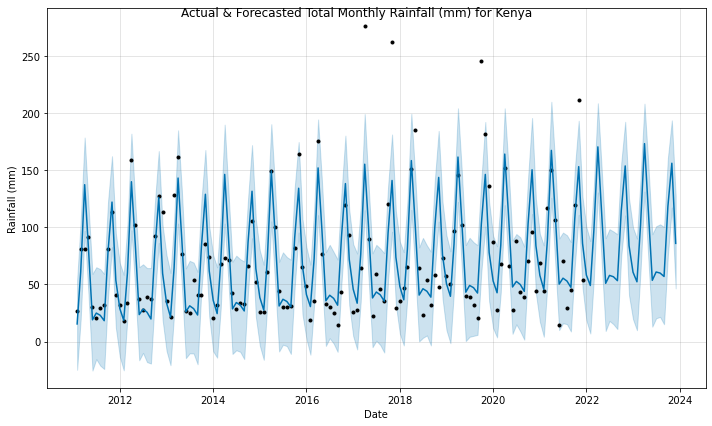

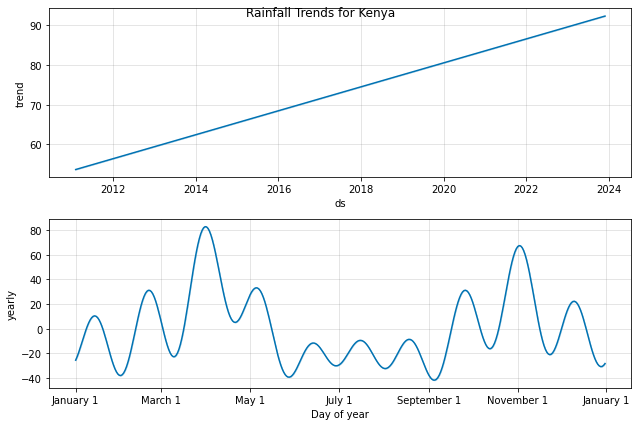

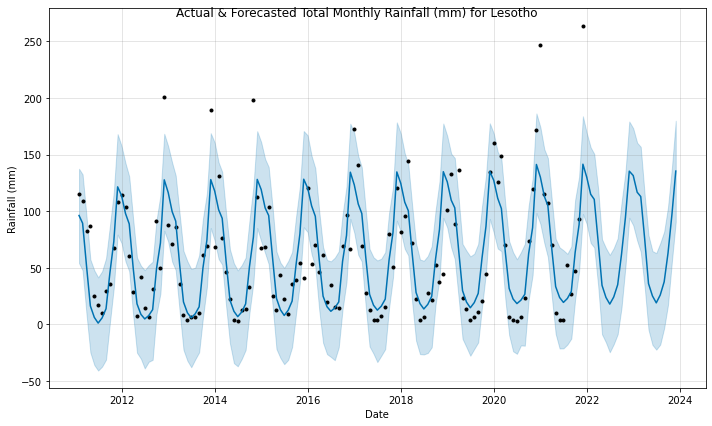

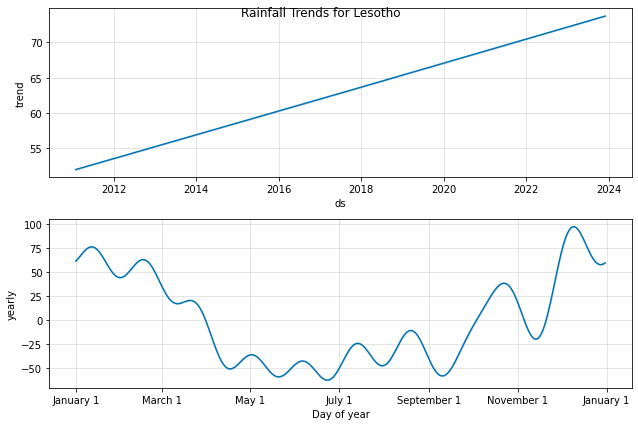

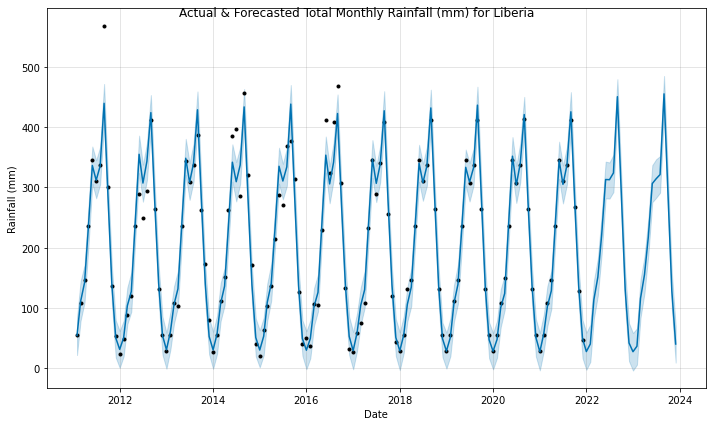

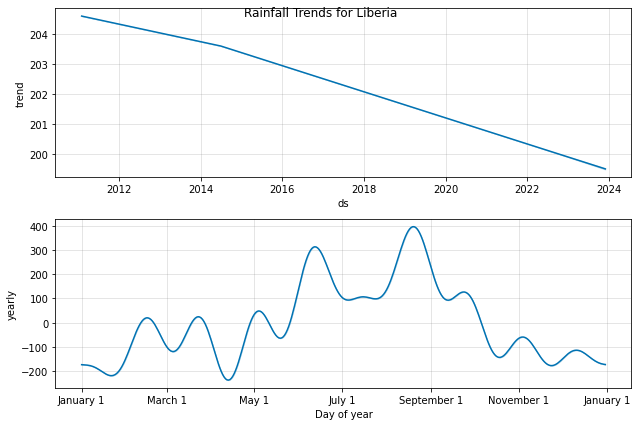

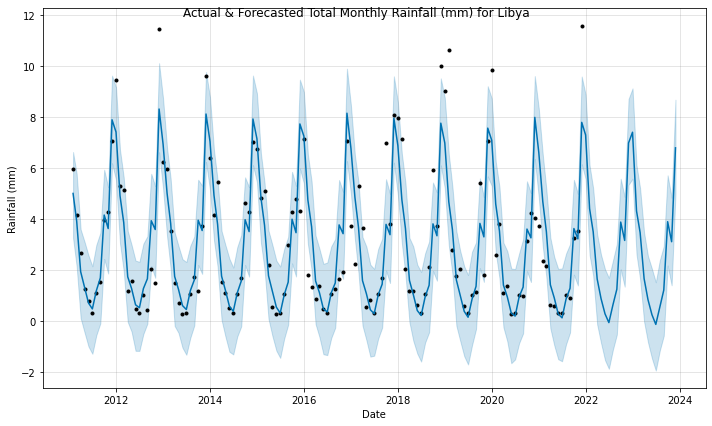

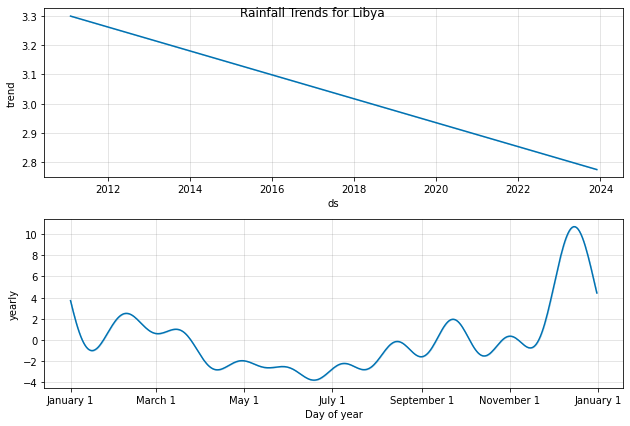

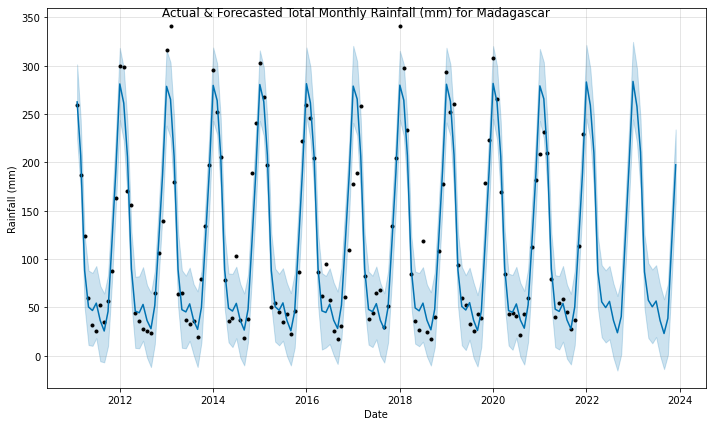

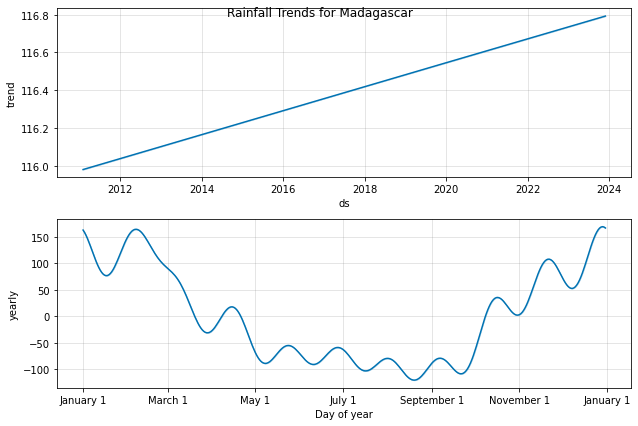

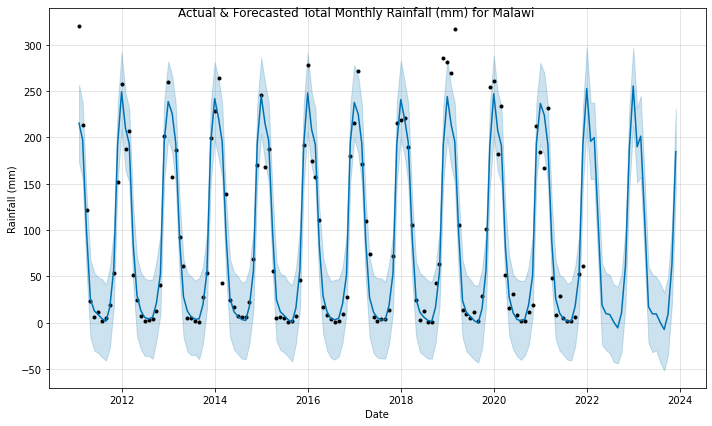

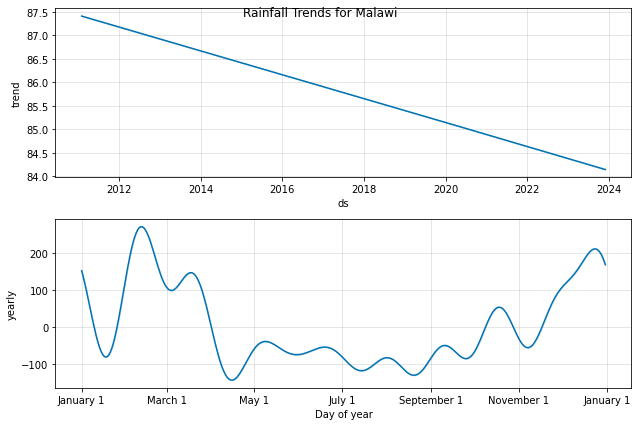

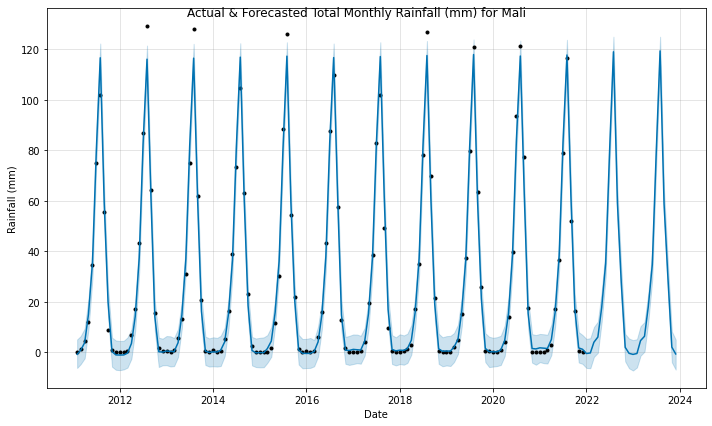

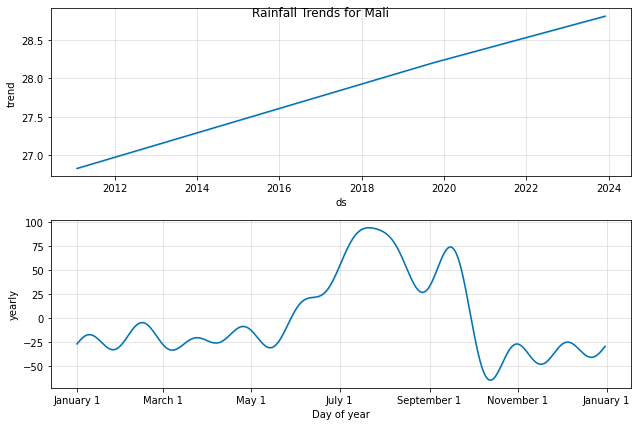

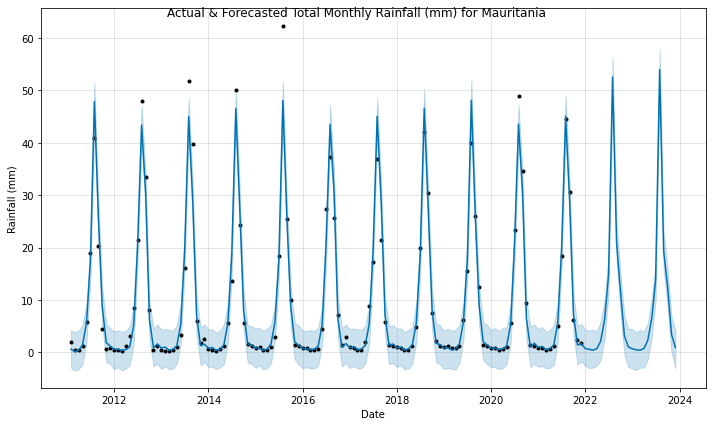

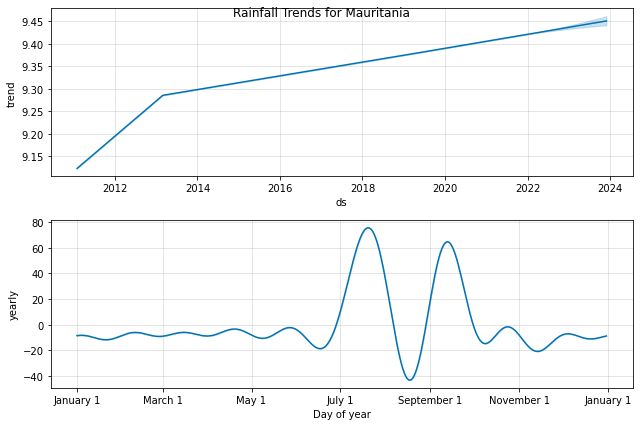

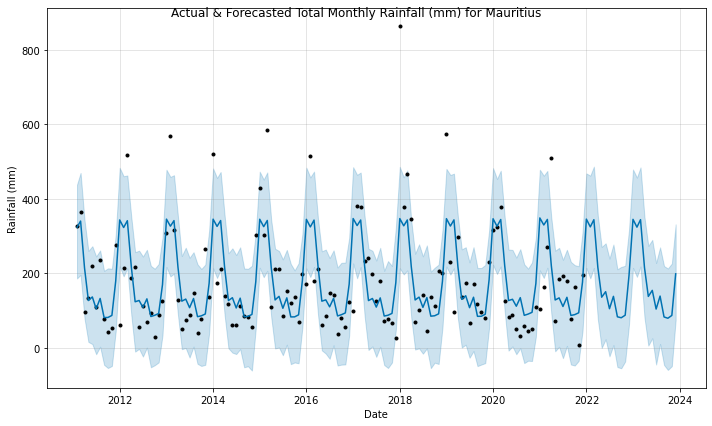

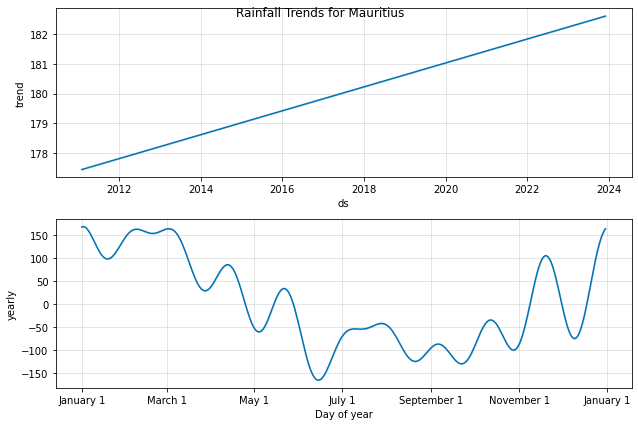

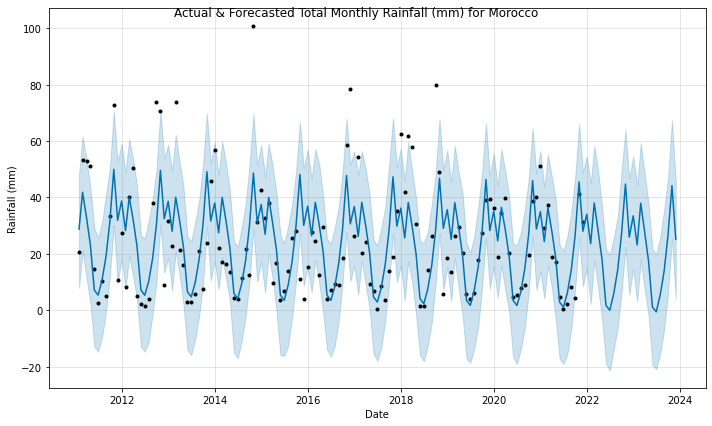

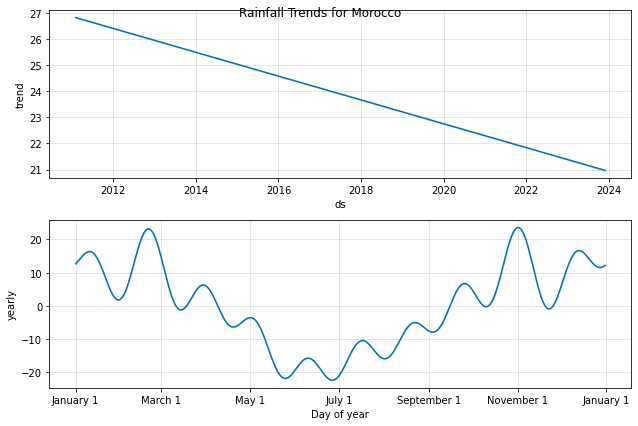

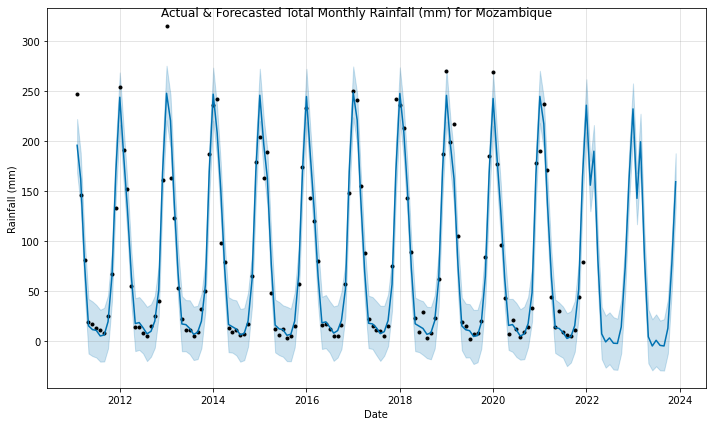

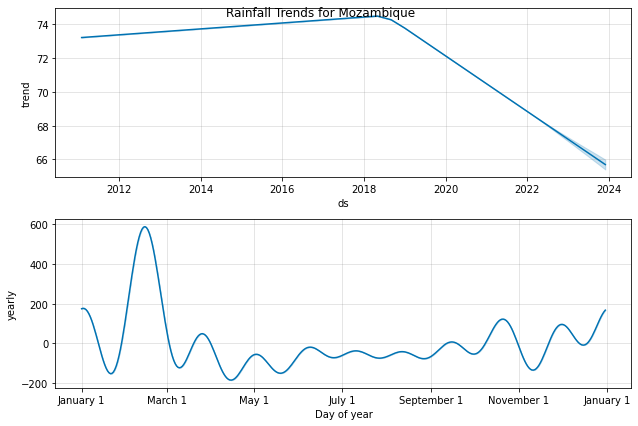

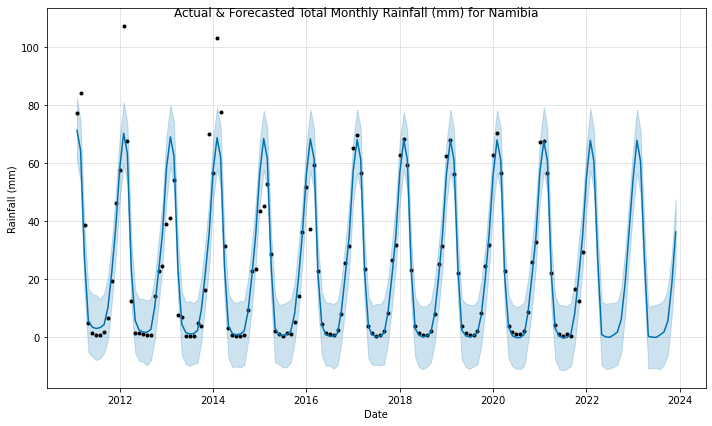

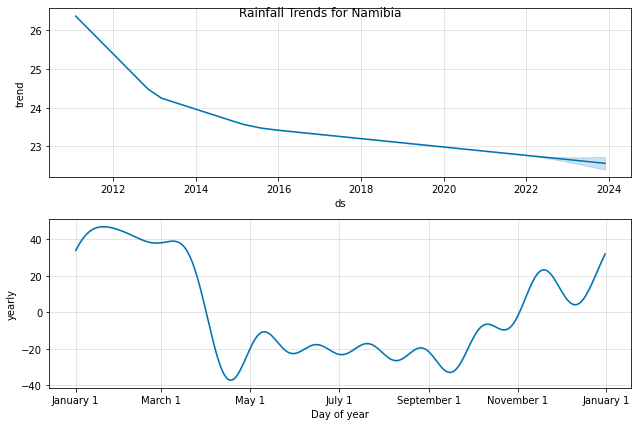

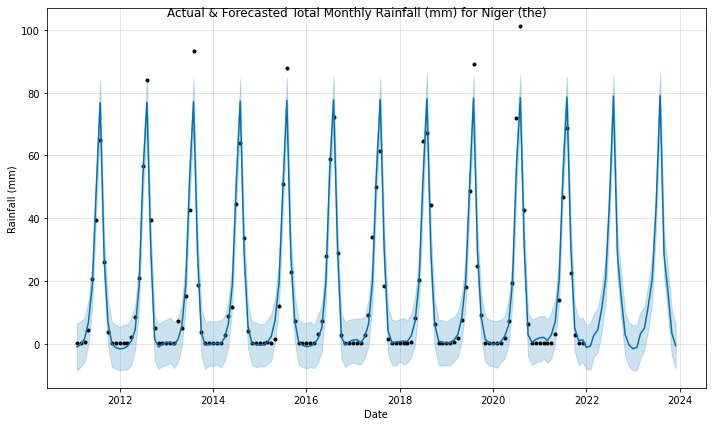

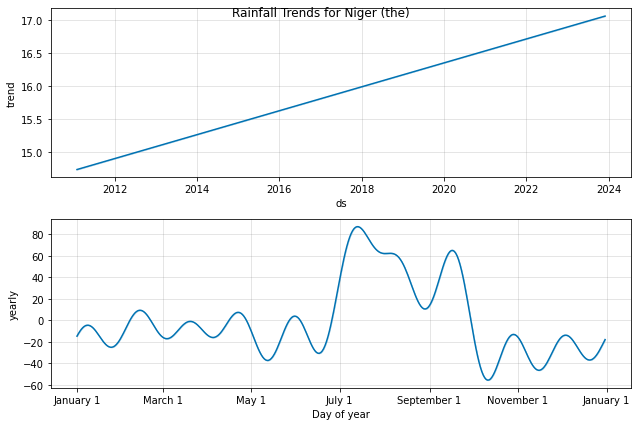

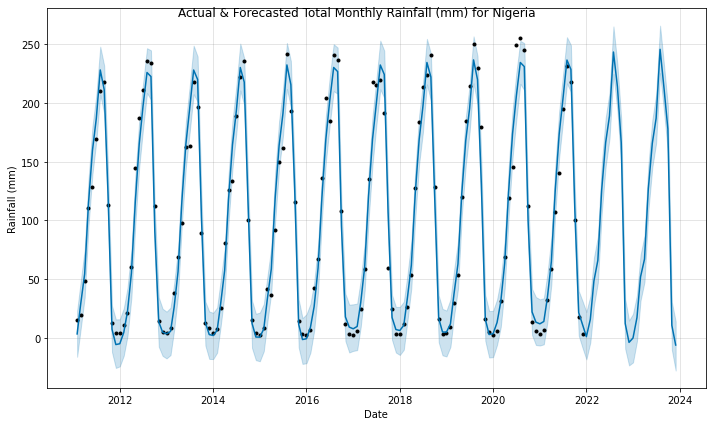

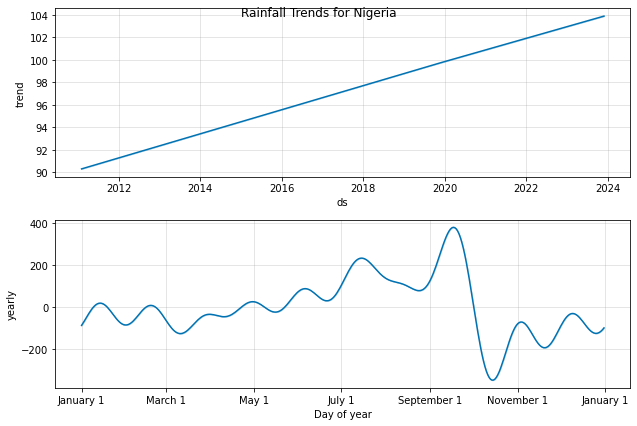

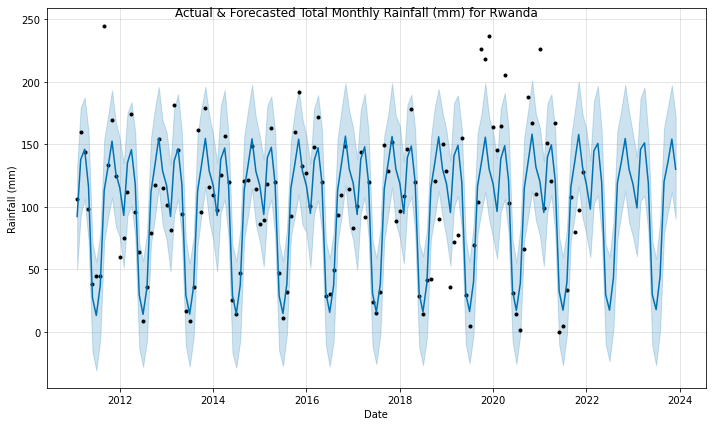

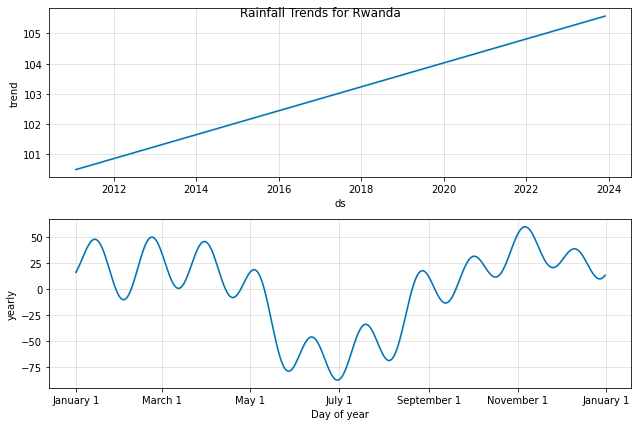

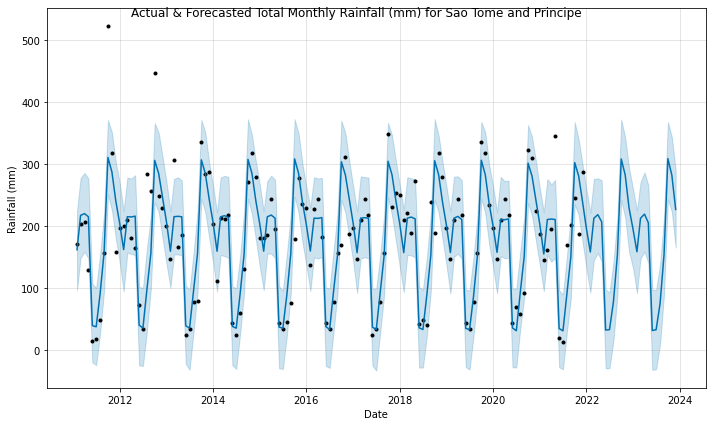

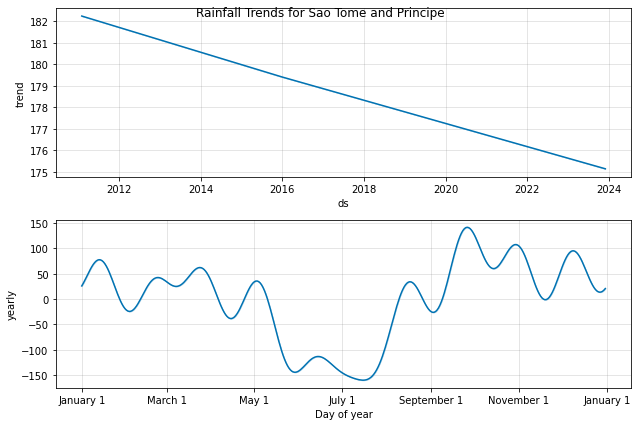

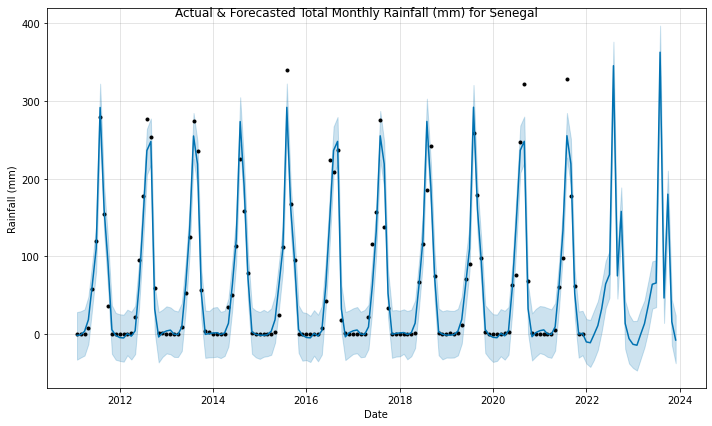

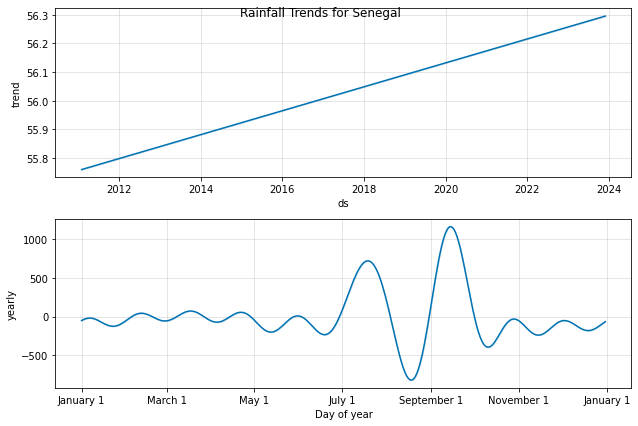

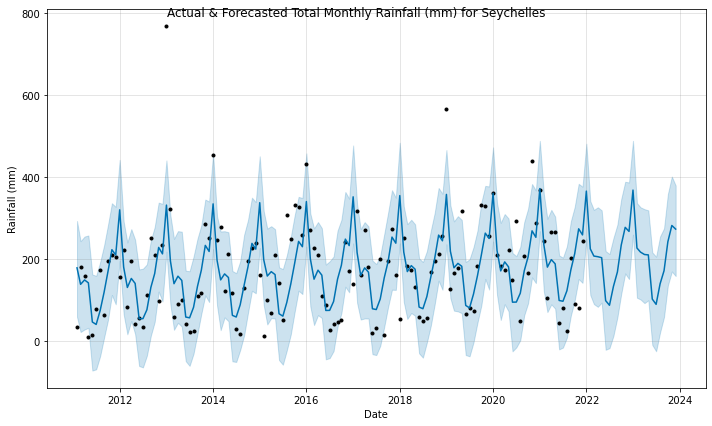

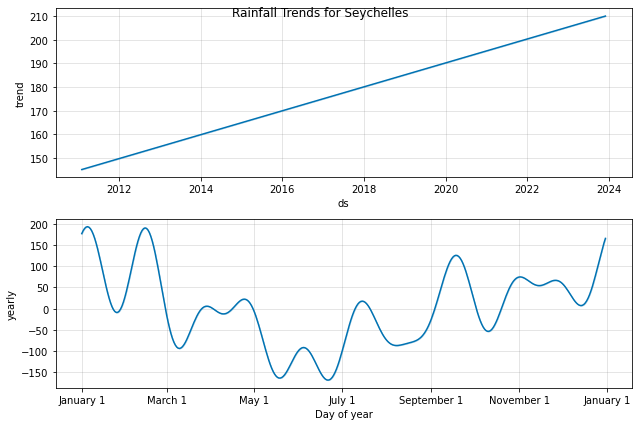

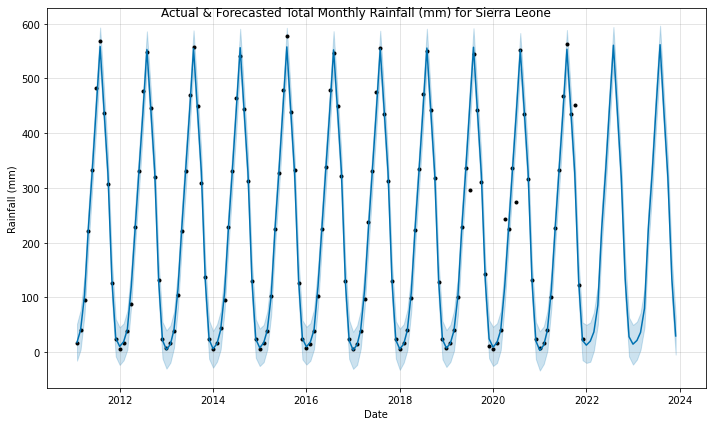

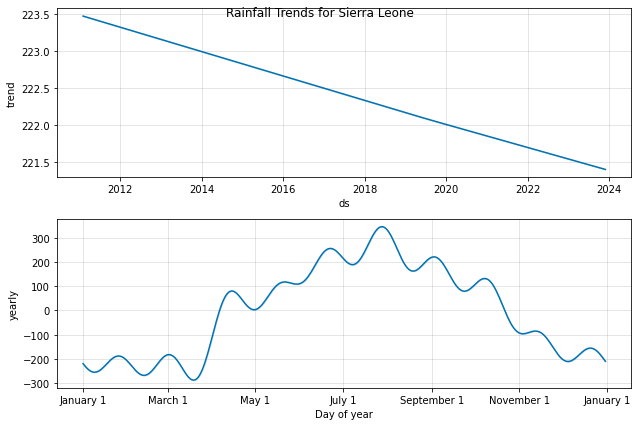

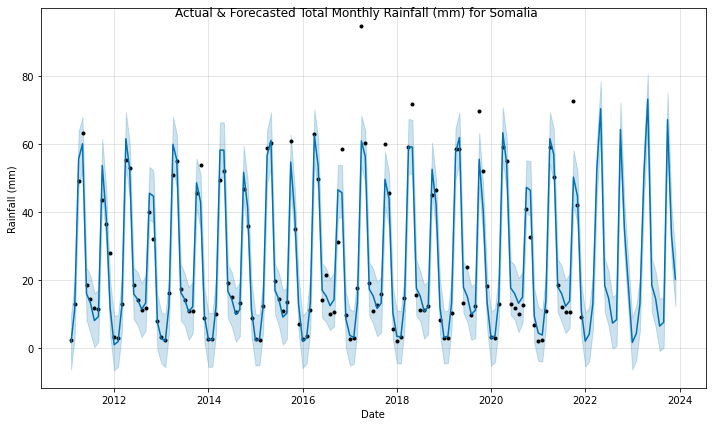

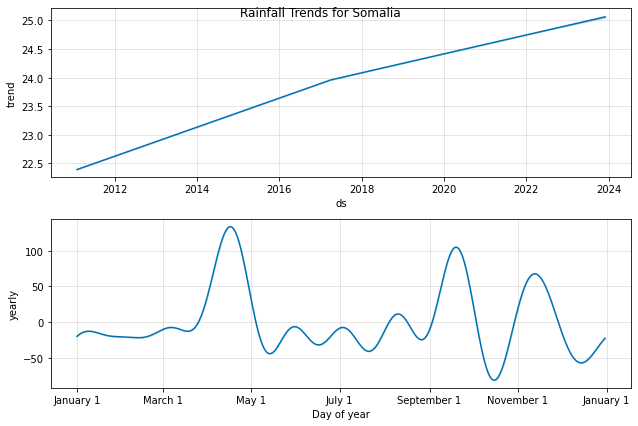

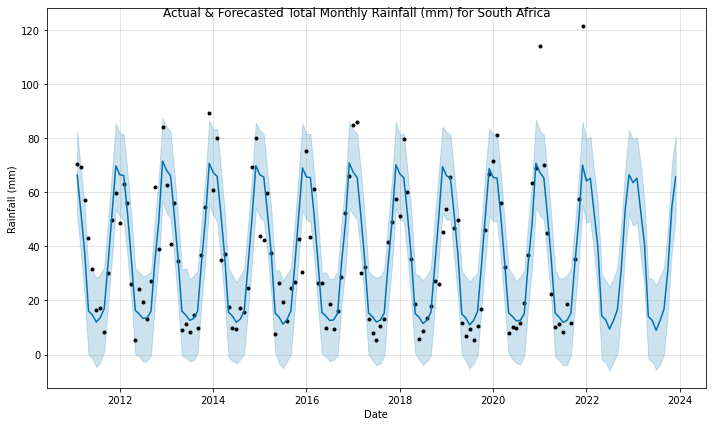

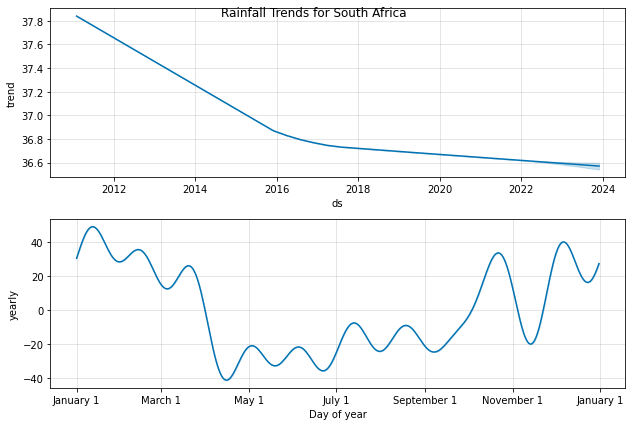

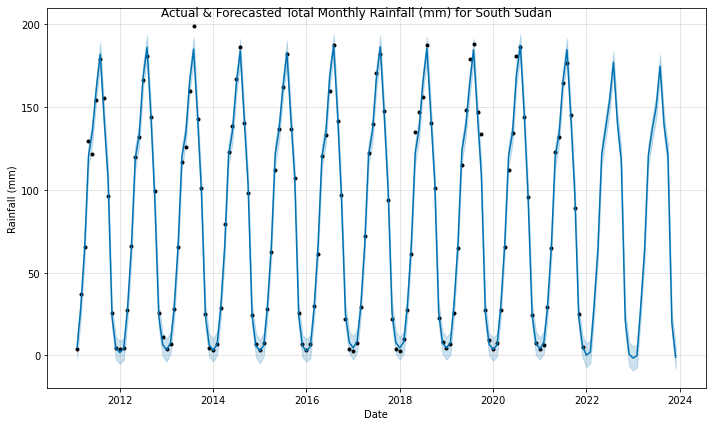

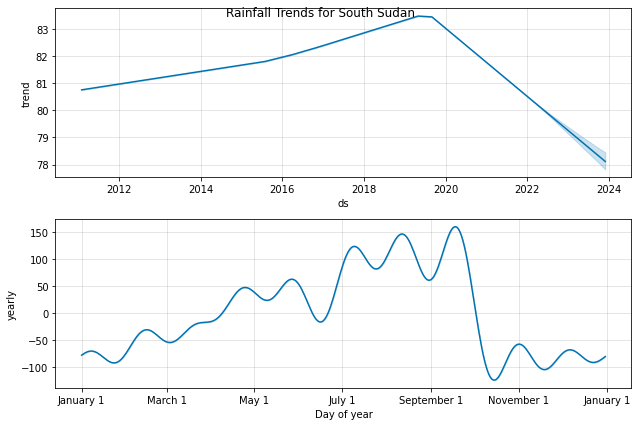

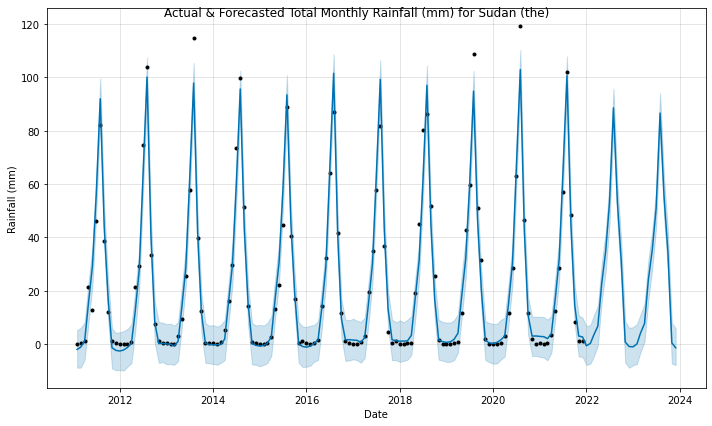

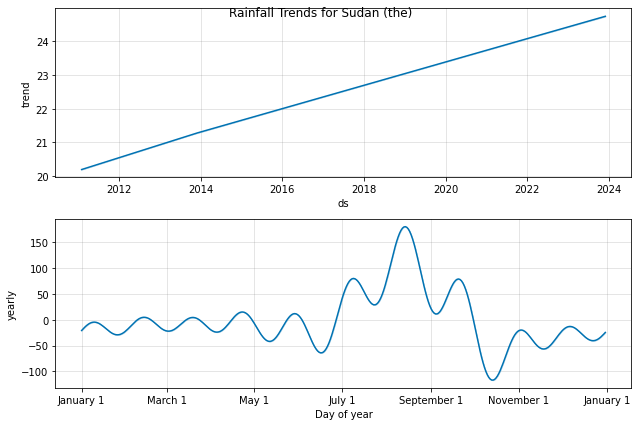

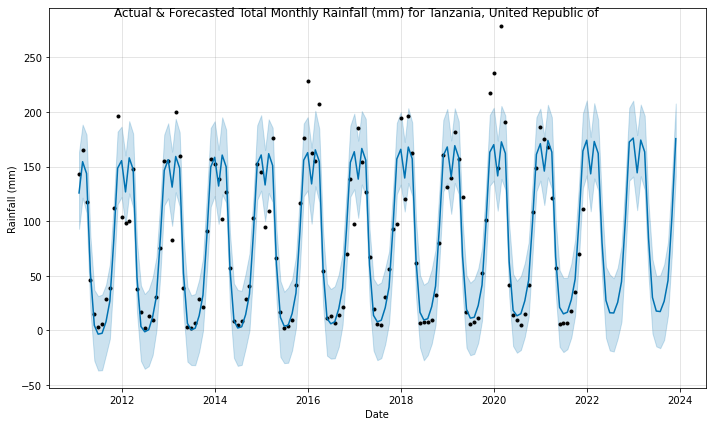

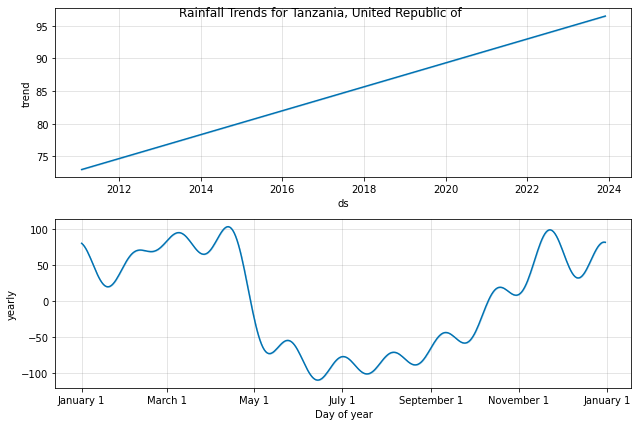

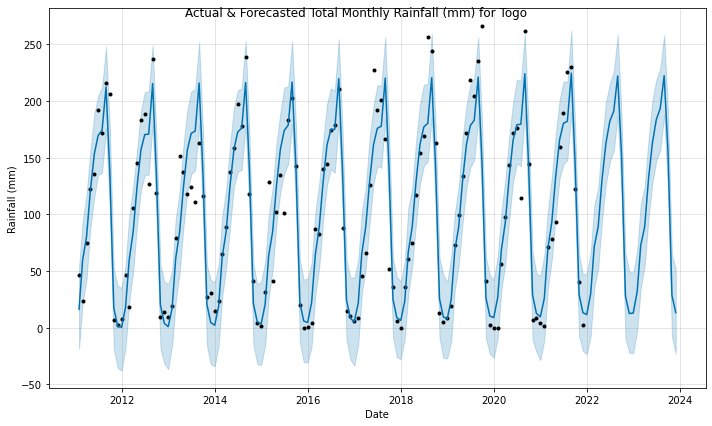

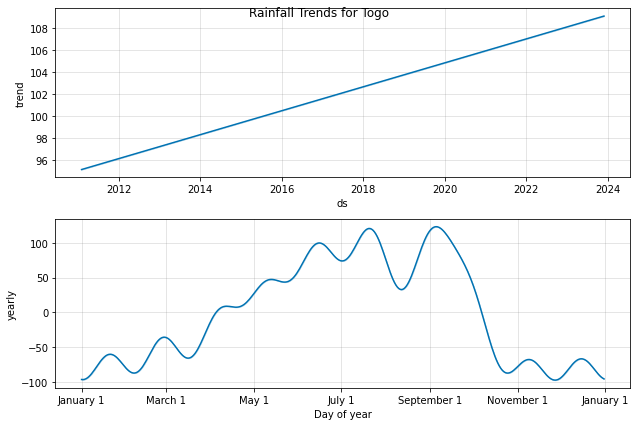

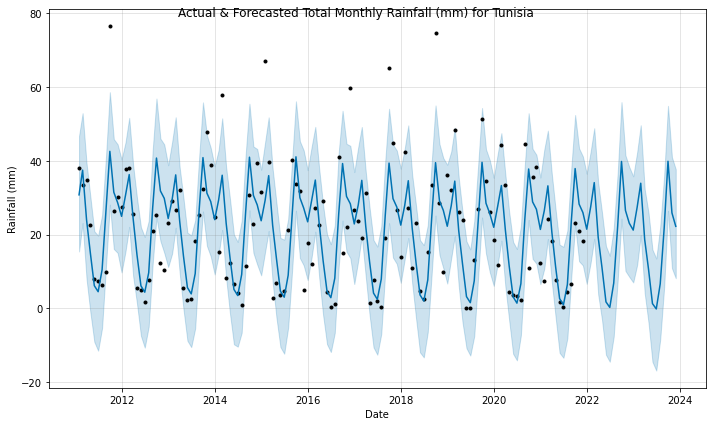

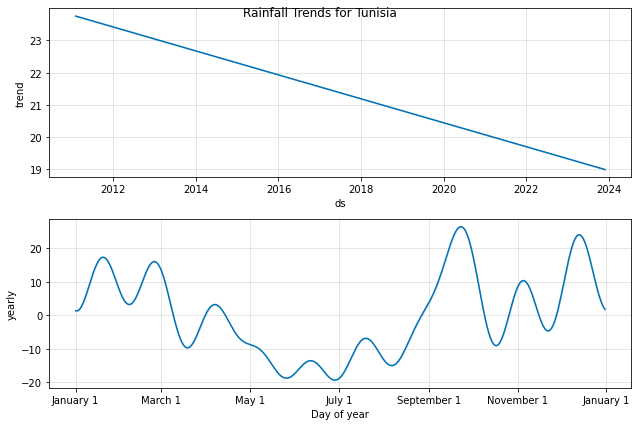

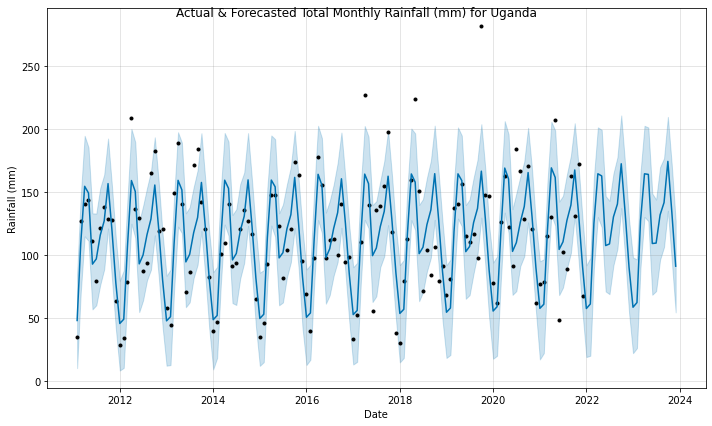

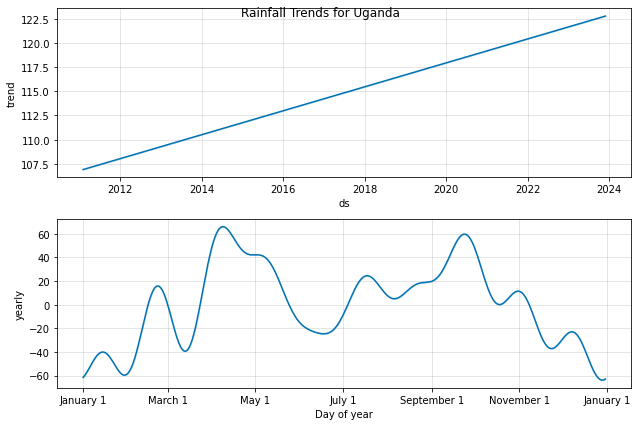

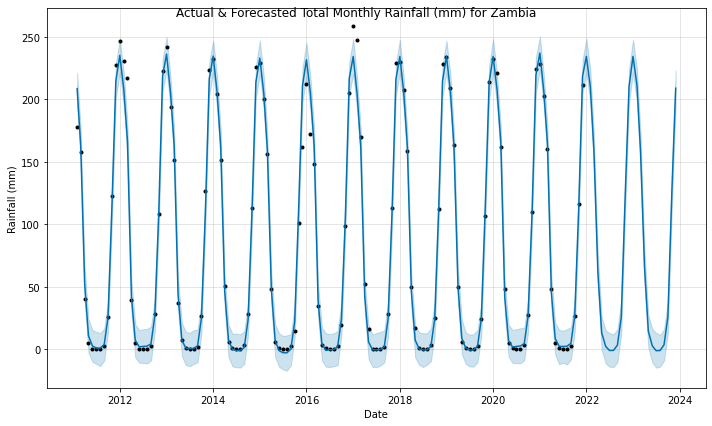

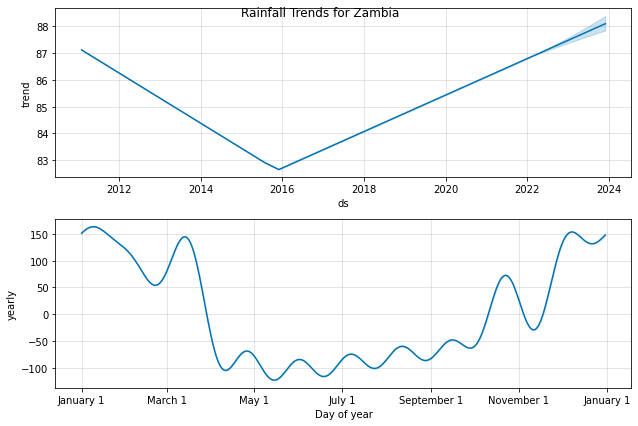

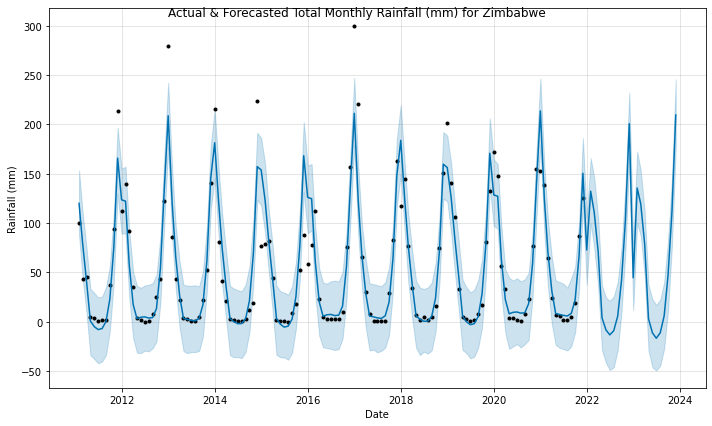

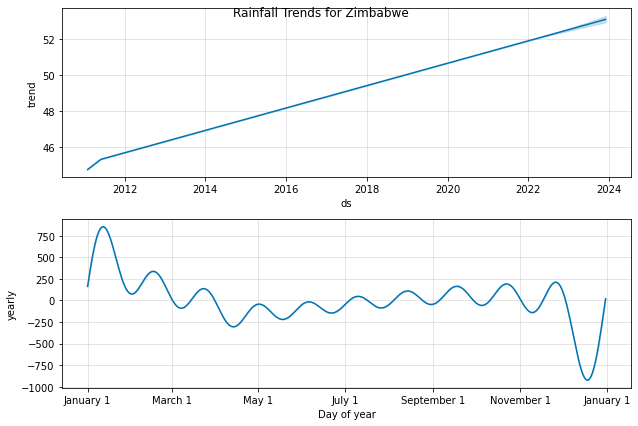

In [17]:
rainfall_forecast_dict = {}
for country, df in rainfall_t_dict.items():
    forecast = make_prophet_predictions(df, country, 'rainfall')
    rainfall_forecast_dict[country] = forecast

In [ ]:
temp_forecast_dict = {}
for country, df in temp_t_dict.items():
    forecast = make_prophet_predictions(df, country, 'temp')
    temp_forecast_dict[country] = forecast

13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:52 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Algeria


13:12:54 - cmdstanpy - INFO - Chain [1] start processing
13:12:54 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Angola


13:12:56 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Benin


13:12:59 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Botswana


13:13:01 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Burkina Faso


13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Burundi


13:13:04 - cmdstanpy - INFO - Chain [1] start processing
13:13:04 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Cabo Verde


13:13:06 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Cameroon


13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Central African Republic (the)


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Chad


13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Comoros (the)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/prophet/plot.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
13:13:14 - cmdstanpy - INFO - Chain [1] start processing
13:13:14 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Congo (Democratic Republic of)


13:13:16 - cmdstanpy - INFO - Chain [1] start processing
13:13:16 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Congo (Republic of)


13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Côte d'Ivoire


13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Djibouti


13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:22 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Egypt


13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:24 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Equatorial Guinea


13:13:26 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Eritrea


13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Eswatini


13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Ethiopia


13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:32 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Gabon


13:13:33 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Gambia (the)


13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Ghana


13:13:37 - cmdstanpy - INFO - Chain [1] start processing
13:13:37 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Guinea


13:13:39 - cmdstanpy - INFO - Chain [1] start processing
13:13:39 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Guinea-Bissau


13:13:41 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Kenya


13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Lesotho


13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:45 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Liberia


13:13:47 - cmdstanpy - INFO - Chain [1] start processing
13:13:47 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Libya


13:13:49 - cmdstanpy - INFO - Chain [1] start processing
13:13:49 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Madagascar


13:13:51 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Malawi


13:13:53 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mali


13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mauritania


13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:13:57 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mauritius


13:13:59 - cmdstanpy - INFO - Chain [1] start processing
13:13:59 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Morocco


13:14:01 - cmdstanpy - INFO - Chain [1] start processing
13:14:01 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Mozambique


13:14:03 - cmdstanpy - INFO - Chain [1] start processing
13:14:03 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Namibia


13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Niger (the)


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Nigeria


13:14:09 - cmdstanpy - INFO - Chain [1] start processing
13:14:09 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Rwanda


13:14:11 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Sao Tome and Principe


13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Senegal


13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Seychelles


13:14:17 - cmdstanpy - INFO - Chain [1] start processing
13:14:17 - cmdstanpy - INFO - Chain [1] done processing


Analysing for Country: Sierra Leone


### Step 4: Export Predictions

In [ ]:
def pivot_and_save(forecast_dict, variable):
    final_dfs = []

    for country, df in forecast_dict.items():
        df['yhat']=round(df['yhat'],2)
        df = df.pivot_table(values='yhat',columns='ds').reset_index(drop=True)
        df.columns=df.columns.date
        df.insert(0, 'country_name', country)
        df.insert(1, 'country_code_alpha2', mapping_dict[country])
        final_dfs.append(df)
        
    final_df = pd.concat(final_dfs)
    final_df.to_csv(os.path.join(root_wd,f"data/weather/{variable}_forecasted.csv"), index=False)
    return final_df

In [ ]:
pivot_and_save(rainfall_forecast_dict,'rainfall')

In [ ]:
pivot_and_save(temp_forecast_dict,'temp')